NOTE: Must upload tRNAs_clusters_updated.tsv, train/test split csv files for sequences and percentages to be able to run the notebook

## Load Packages

In [ ]:
#!pip install wandb
#!wandb login
#!pip install --upgrade wandb

In [ ]:
!pip install Levenshtein

In [ ]:
# Check if running in Colab and install necessary packages
def is_running_colab():
    try:
        from google.colab import drive
        return True
    except ImportError:
        return False

In [ ]:
# Check if running in Colab and install necessary packages
def is_running_colab():
    try:
        from google.colab import drive
        return True
    except ImportError:
        return False

if is_running_colab():
    !pip install -q condacolab
    import condacolab
    condacolab.install()
    #!conda install -c conda-forge -c bioconda mmseqs2 -y
    !pip install Levenshtein
else:
    print("Running locally. No need to install packages.")

✨🍰✨ Everything looks OK!


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from random import randint, sample
from typing import Sequence, Tuple, List, Union

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, precision_recall_curve, auc

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from xgboost import XGBRegressor
from Levenshtein import distance


import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import KFold, GridSearchCV, train_test_split

import os

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from sklearn.metrics import r2_score, mean_squared_error

from scipy import stats
import numpy as np

## Loading Data

In [ ]:
if is_running_colab():
    # Path for Google Colab
    from google.colab import drive
    drive.mount('/content/drive')
    file_path = '/content/drive/MyDrive/tRNAs_charging_data_correct.csv'
    print('Running on Google Collab')
else:
    # Path for local machine
    file_path = 'tRNAs_charging_data_correct.csv'
    print('Running locally')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running on Google Collab


In [ ]:
df = pd.read_csv(file_path)
df = df.rename(columns={'tRNA_sequence': 'seq', 'aminoacylation percentage': 'perc'})

# Baseline Modeling, Train_Test_Splitting, Clustering

## EDA

### HistPlot: EDA (DONT RUN)

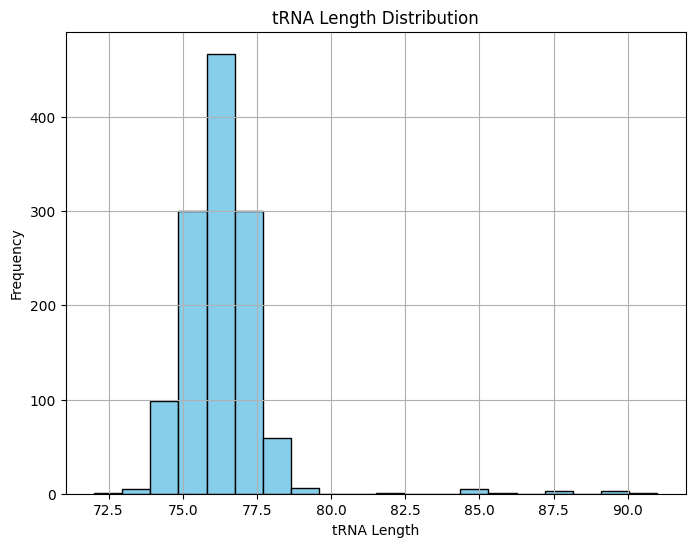

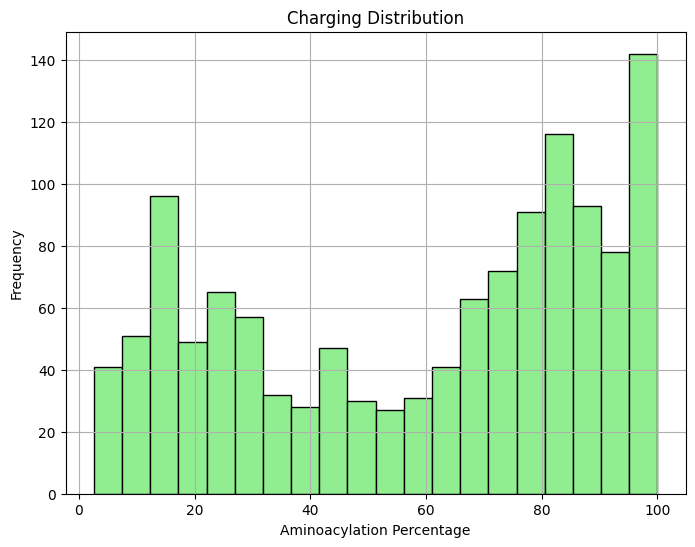

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df.seq.apply(len), bins=20, color='skyblue', edgecolor='black')
plt.title('tRNA Length Distribution')
plt.xlabel('tRNA Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(df.perc, bins=20, color='lightgreen', edgecolor='black')
plt.title('Charging Distribution')
plt.xlabel('Aminoacylation Percentage')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

levenshtein_distances = []
for i in range(len(df)):
    for j in range(i+1, len(df)):
        distance_ij = distance(df.seq[i], df.seq[j])
        levenshtein_distances.append(distance_ij)

plt.figure(figsize=(8, 6))
plt.hist(levenshtein_distances, bins=20, color='lightcoral', edgecolor='black')
plt.title('Levenshtein Distance Distribution')
plt.xlabel('Levenshtein Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Preprocessing

### Preprocessing - OHE + Scaling Example

In [ ]:
ohe_map = {'A' : [1,0,0,0,0], 'T' : [0,1,0,0,0], 'C' : [0,0,1,0,0], 'G' : [0,0,0,1,0], 'pad' : [0,0,0,0,1]}

seqs = df.seq.tolist()
perc = np.array(df.perc.tolist()).reshape(-1,1)/100
max_length = max(len(seq) for seq in seqs)
bio_seqs = [seq.ljust(max_length, '-') for seq in seqs]
num_seqs = []
# Adding padding to sequences
for seq in bio_seqs:
    num_seq = []
    for nucleotide in seq:
        if nucleotide == '-':
            num_seq.append('pad')
        else:
            num_seq.append(nucleotide)
    num_seqs.append(num_seq)

print(f"Number of sequences: {len(num_seqs)}")  # Check number of sequences
# One Hot Encoding using the OHE_Map
transformed_seqs = []
for seq in num_seqs:
  current_transformed_seqs = []
  for nucleotide in seq:
    transformed_nucleotide = ohe_map[nucleotide]
    current_transformed_seqs.append(transformed_nucleotide)
  transformed_seqs.append(current_transformed_seqs)
print(f"Number of transformed sequences: {len(transformed_seqs)}")  # Check number of transformed sequences

# Verify the length of each sequence and the transformation
for i, seq in enumerate(transformed_seqs[:5]):  # Check first 5 sequences for brevity
    print(f"Original sequence {i}: {num_seqs[i]}")
    print(f"Transformed sequence {i}: {seq}")

# Convert transformed_seqs to numpy array if needed
transformed_seqs = np.array(transformed_seqs)

# Display shape of transformed sequences
print(f"Shape of transformed sequences: {transformed_seqs.shape}")

#seq_mat = np.array(num_seqs)
#max_length = max(len(transformed_seqs[i]) for i in range(len(transformed_seqs)))
#max_length

Number of sequences: 1250
Number of transformed sequences: 1250
Original sequence 0: ['G', 'C', 'G', 'T', 'C', 'T', 'G', 'T', 'A', 'G', 'T', 'C', 'C', 'A', 'A', 'C', 'G', 'G', 'T', 'T', 'A', 'G', 'G', 'A', 'T', 'A', 'A', 'T', 'T', 'G', 'C', 'C', 'T', 'T', 'C', 'C', 'A', 'A', 'G', 'C', 'A', 'A', 'T', 'A', 'G', 'A', 'C', 'C', 'C', 'G', 'G', 'G', 'T', 'T', 'C', 'G', 'A', 'C', 'T', 'C', 'C', 'C', 'G', 'G', 'C', 'A', 'G', 'A', 'C', 'G', 'C', 'A', 'C', 'C', 'A', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
Transformed sequence 0: [[0, 0, 0, 1, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 1, 0], [1, 0, 0, 0

## Clustering with MMSEQ2 - New Attempt

### Read Clustering Results

In [ ]:
clusters_file_path = 'tRNAs_clusters_updated.tsv'
clusters_data = pd.read_csv(clusters_file_path, sep='\t', header=None)

### Compute μ,σ of Distances

Aggregate Mean Distance: 31.902032688629955
Aggregate Std Deviation: 4.9520008345843705


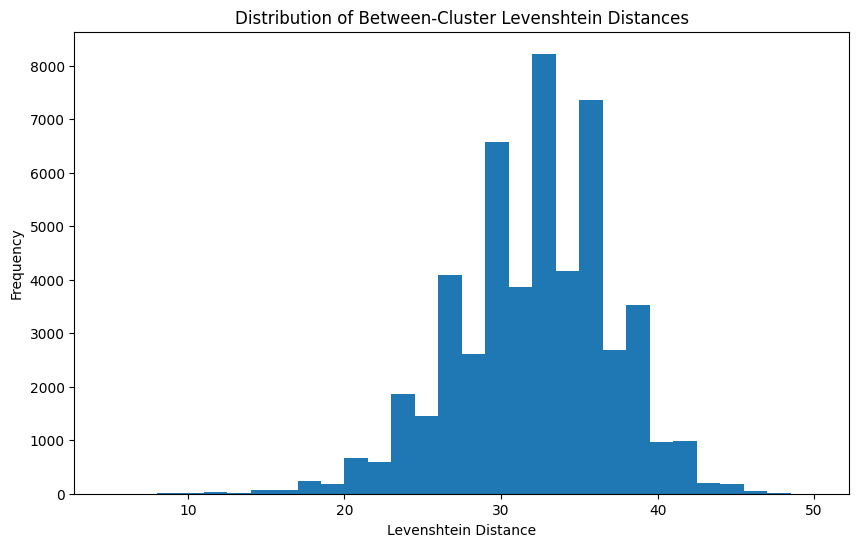

{'between_cluster_distances': [36,
  38,
  26,
  23,
  37,
  31,
  35,
  31,
  38,
  27,
  45,
  25,
  32,
  28,
  38,
  29,
  33,
  27,
  38,
  34,
  31,
  25,
  34,
  30,
  31,
  32,
  24,
  35,
  39,
  26,
  30,
  40,
  32,
  34,
  33,
  39,
  29,
  29,
  36,
  34,
  24,
  30,
  32,
  34,
  27,
  31,
  34,
  38,
  26,
  40,
  27,
  39,
  25,
  30,
  35,
  34,
  23,
  35,
  36,
  32,
  25,
  41,
  33,
  25,
  32,
  35,
  35,
  29,
  38,
  34,
  38,
  31,
  31,
  37,
  27,
  29,
  32,
  29,
  37,
  31,
  35,
  29,
  30,
  20,
  31,
  28,
  31,
  30,
  23,
  35,
  25,
  34,
  32,
  27,
  28,
  32,
  30,
  34,
  31,
  33,
  31,
  23,
  37,
  35,
  23,
  31,
  18,
  32,
  32,
  28,
  35,
  29,
  30,
  25,
  32,
  34,
  33,
  21,
  30,
  28,
  30,
  32,
  38,
  24,
  33,
  27,
  33,
  36,
  28,
  23,
  33,
  29,
  33,
  36,
  31,
  31,
  26,
  30,
  29,
  23,
  33,
  35,
  43,
  28,
  22,
  31,
  28,
  27,
  36,
  26,
  34,
  26,
  35,
  20,
  26,
  28,
  32,
  37,
  30,
  36,
  36,
  42,

In [ ]:
def calculate_cluster_stats_and_plots(clusters_data, seqs):
    # Function to get sequences for a given cluster
    def get_sequences_for_cluster(cluster_id):
        cluster_sequences = cluster_assignments[cluster_assignments[0] == cluster_id][1].tolist()
        return [sequences[i] for i in cluster_sequences]

    # Calculates pairwise Levenshtein distances for all sequences within one cluster
    def compute_mean_std_distances(sequences):
        num_sequences = len(sequences)

        # Handle 1 sequence clusters
        if num_sequences < 2:
            return np.nan, np.nan

        distances = []
        for i in range(num_sequences):
            for j in range(i + 1, num_sequences):
                distances.append(distance(sequences[i], sequences[j]))
        if len(distances) == 0:
            return 0, 0
        mean_dist = np.mean(distances)
        std_dist  = np.std(distances)

        # Handle Identical sequences
        if mean_dist == 0:
            std_dist = 0  # If mean distance is zero, std deviation should be zero as well

        return mean_dist, std_dist

    # Function to get the centroid sequence for a given cluster (assuming the first sequence as the centroid)
    def get_centroid_for_cluster(cluster_id):
        return sequences[cluster_id]

    cluster_assignments = clusters_data
    unique_clusters = cluster_assignments[0].unique()
    sequences = seqs

    # Calculate centroid sequences
    centroid_sequences = {cluster: get_centroid_for_cluster(cluster) for cluster in unique_clusters}

    # Calculate between-cluster distances
    between_cluster_distances = {}
    distances = []
    centroid_clusters = list(centroid_sequences.keys())
    for i in range(len(centroid_clusters)):
        for j in range(i + 1, len(centroid_clusters)):
            cluster1 = centroid_clusters[i]
            cluster2 = centroid_clusters[j]
            centroid1 = centroid_sequences[cluster1]
            centroid2 = centroid_sequences[cluster2]
            if centroid1 is not None and centroid2 is not None:
                dist = distance(centroid1, centroid2)
                distances.append(dist)
    mean_dist = np.mean(distances)
    std_dist  = np.std(distances)
    print(f"Aggregate Mean Distance: {mean_dist}")
    print(f"Aggregate Std Deviation: {std_dist}")

    # Plot between-cluster distance distribution
    plt.figure(figsize=(10, 6))
    plt.hist(distances, bins=30)
    plt.xlabel('Levenshtein Distance')
    plt.ylabel('Frequency')
    plt.title('Distribution of Between-Cluster Levenshtein Distances')
    plt.show()

    # Compute distances within each cluster
    within_cluster_distances = {}
    for cluster in unique_clusters:
        cluster_sequences = get_sequences_for_cluster(cluster)
        mean_dist, std_dist = compute_mean_std_distances(cluster_sequences)
        within_cluster_distances[cluster] = (mean_dist, std_dist)

    within_cluster_mean_std = pd.DataFrame(within_cluster_distances, index=['Mean Distance', 'Std Distance']).T
    within_cluster_mean_std.reset_index(inplace=True)
    within_cluster_mean_std.rename(columns={'index': 'Cluster'}, inplace=True)
    distances_df_sorted = within_cluster_mean_std.sort_values(by='Mean Distance')

    '''
    # Plot within-cluster mean and standard deviation distances
    plt.figure(figsize=(50, 10))
    sns.barplot(x='Cluster', y='Mean Distance', data=distances_df_sorted, yerr=distances_df_sorted['Std Distance'], capsize=0.2, palette='viridis', hue='Cluster', legend=False)
    plt.xlabel('Cluster ID')
    plt.ylabel('Mean Distance with Std Error')
    plt.title('Within-Cluster Mean and Standard Deviation of Distances (First 100 Clusters)')
    plt.xticks(rotation=90)
    plt.ylim(0, distances_df_sorted['Mean Distance'].max() + distances_df_sorted['Std Distance'].max())
    plt.show()
    '''

    return {
        'between_cluster_distances': distances,
        'within_cluster_mean_std': within_cluster_mean_std
    }

results = calculate_cluster_stats_and_plots(clusters_data, seqs)
cluster_assignments = clusters_data
unique_clusters = cluster_assignments[0].unique()
sequences = seqs
results

### Preprocessing + Intializing Fns

#### Preprocessing Function

In [ ]:
def preprocess_data(sequences, percentages):

    # Convert percentages to decimals
    perc = np.array(percentages).reshape(-1, 1) / 100

    # Find the maximum sequence length
    max_length = 91

    # Adding padding to sequences
    bio_seqs = [(seq.ljust(max_length, '-')) for seq in sequences]
    num_seqs = []
    for seq in bio_seqs:
        num_seq = []
        for nucleotide in seq:
            if nucleotide == '-':
                num_seq.append('pad')
            else:
                num_seq.append(nucleotide)
        num_seqs.append(num_seq)

    print(f"Number of sequences: {len(num_seqs)}")  # Check number of sequences

    ohe_map = {'A' : [1,0,0,0,0], 'T' : [0,1,0,0,0], 'C' : [0,0,1,0,0], 'G' : [0,0,0,1,0], 'pad' : [0,0,0,0,1]}
    # One Hot Encoding using the OHE_Map
    transformed_seqs = []
    for seq in num_seqs:
        current_transformed_seq = []
        for nucleotide in seq:
            transformed_nucleotide = ohe_map[nucleotide]
            current_transformed_seq.append(transformed_nucleotide)
        transformed_seqs.append(current_transformed_seq)

    print(f"Number of transformed sequences: {len(transformed_seqs)}")  # Check number of transformed sequences

    # Verify the length of each sequence and the transformation
    for i, seq in enumerate(transformed_seqs[:5]):  # Check first 5 sequences for brevity
        print(f"Original sequence {i}: {num_seqs[i]}")
        print(f"Transformed sequence {i}: {seq}")

    # Convert transformed_seqs to numpy array if needed
    transformed_seqs = np.array(transformed_seqs)

    return transformed_seqs, perc

#### Assign Sequences to Sets based on clusters

In [ ]:
# Function to assign sequences to sets based on clusters
def assign_sequences_to_set(clusters, cluster_assignments, sequences):
    assigned_sequences = []
    assigned_indices = []
    for cluster in clusters:
        cluster_sequences = cluster_assignments[cluster_assignments[0] == cluster][1].tolist()
        assigned_sequences.extend([sequences[i] for i in cluster_sequences])
        assigned_indices.extend(cluster_sequences)
    return assigned_sequences, assigned_indices

#### Find Most Similar Train seq To a Given Val Seq

In [ ]:
# Function to find the most similar sequence in training set
def find_most_similar_sequence(validation_seq, training_seqs):
    min_distance = float('inf')
    most_similar_seq = None
    for train_seq in training_seqs:
        dist = distance(validation_seq, train_seq)
        if dist < min_distance:
            min_distance = dist
            most_similar_seq = train_seq
    return most_similar_seq, min_distance

#### Check for Anomalous values

In [ ]:
mae_threshold = 1e+08
def check_aminoacylation_threshold(y_pred, y_fold_val, sequences, mae ,train_fold_idx, val_idx, fold_number):
    if mae > mae_threshold:
        print(f"-----High MAE detected in Fold {fold_number} with MAE: {mae}-------")
        for idx, val in enumerate(val_idx):
            print(f"Validation Sequence Index: {val}")
            print(f"Predicted Value: {y_pred[idx]}, Actual Value: {y_fold_val[idx]}")
            print(f"Validation Sequence: {sequences[val]}")

    # Check for predictions out of the expected range [0, 1]
    out_of_range_indices = [idx for idx, pred in enumerate(y_pred) if pred < 0 or pred > 1]
    if out_of_range_indices:
        print(f'Predictions out of range [0, 1] detected in Fold {fold_number}')
        for idx in out_of_range_indices:
            val = val_idx[idx]
            print(f"Validation Sequence Index: {val}")
            print(f"Predicted Value: {y_pred[idx]}, Actual Value: {y_fold_val[idx]}")
            print(f"Validation Sequence: {sequences[val]}")



#### Reverse Transform Sequence

In [ ]:
def reverse_transform(transformed_seqs):
    # Map to convert one-hot encoding back to nucleotide
    reverse_ohe_map = {
        (1, 0, 0, 0, 0): 'A',
        (0, 1, 0, 0, 0): 'T',
        (0, 0, 1, 0, 0): 'C',
        (0, 0, 0, 1, 0): 'G',
        (0, 0, 0, 0, 1): '-'
    }

    def transform_single_seq(reshaped_seq):
        seq_length = reshaped_seq.shape[0] // 5
        seq = reshaped_seq.reshape(seq_length, 5)
        return ''.join([reverse_ohe_map[tuple(nucleotide)] for nucleotide in seq]).rstrip('-')

    if isinstance(transformed_seqs, np.ndarray) and transformed_seqs.ndim == 2 and transformed_seqs.shape[1] % 5 == 0:
        original_sequences = [transform_single_seq(seq) for seq in transformed_seqs]
        return original_sequences
    else:
        raise ValueError("Input should be a 2D numpy array with second dimension a multiple of 5.")


#### Cluster Label Finder

In [ ]:
def cluster_label_finder(train_idx):
    clusters_data = pd.read_csv('tRNAs_clusters_updated.tsv', sep='\t', header=None, names=['Cluster_ID', 'Sequence_ID'])

    # Convert 'Sequence_ID' to integer type
    clusters_data['Sequence_ID'] = clusters_data['Sequence_ID'].astype(int)

    # Create a DataFrame with the sequences and their corresponding cluster IDs
    df = pd.DataFrame({
        'sequence': [sequences[i] for i in clusters_data['Sequence_ID']],
        'cluster_id': clusters_data['Cluster_ID']
    })

    # Verify the DataFrame
    df.head()

    all_sequences_df = pd.DataFrame({
        'Sequence_ID': range(len(sequences)),
        'sequence': sequences
    })

    # Merge to ensure all sequences are included
    df = all_sequences_df.merge(clusters_data, on='Sequence_ID', how='left')

    df['Cluster_ID'] = df['Cluster_ID'].fillna(-1)

    df = df.drop(columns=['Sequence_ID'])

    train_cluster_labels = [df.iloc[i]['Cluster_ID'] for i in train_idx]
    test_cluster_labels = [df.iloc[i]['Cluster_ID'] for i in test_idx]

    return train_cluster_labels, test_cluster_labels

### Train Test Split

In [ ]:
train_clusters, test_clusters = train_test_split(unique_clusters, test_size=0.2, random_state=42)
train_sequences, train_idx = assign_sequences_to_set(train_clusters, cluster_assignments, sequences)
test_sequences, test_idx = assign_sequences_to_set(test_clusters, cluster_assignments, sequences)
train_percentages = [df.iloc[i]['perc'] for i in train_idx]
test_percentages = [df.iloc[i]['perc'] for i in test_idx]

try:
    df.iloc[0]['Cluster_ID']
except Exception as e:
    train_cluster_labels, test_cluster_labels = cluster_label_finder(train_idx)
    print(train_cluster_labels)

IndexError: single positional indexer is out-of-bounds

In [ ]:
type(test_sequences)

list

In [ ]:
# Verify that all sequences are correctly encoded in UTF-8
try:
    for i, seq in enumerate(train_sequences):
        seq.encode('utf-8')
except UnicodeEncodeError as e:
    print(f"Encoding error at sequence {i}: {e}")

In [ ]:
# Debugging: Check the type of elements in train_sequences
for i, seq in enumerate(train_sequences):
    print(f"Sequence {i} type: {type(seq)} - Content: {seq}")

Sequence 0 type: <class 'str'> - Content: GCCAACTTAGCTCACCTGGCAGAGCAGCACCCTCGTAACGTGCAGGTACCCGGTTCGAGCCCGGGAGTTGGCTCCA
Sequence 1 type: <class 'str'> - Content: CCGTCGATAGCTCAGTTGGTAGAGCGGAGGACTGTAGATCCTTAGGTCGCTGGTTCGAATCCGGCTCGACGGACCA
Sequence 2 type: <class 'str'> - Content: GGGCCGGTAGTCTAGCGGAAGGATGCCCGCCTCGCGCGCGGGAGATCCCGGGTTCGAATCCCGGCCGGTCCACCA
Sequence 3 type: <class 'str'> - Content: GCTCCTGTAGCTCAGTCGGCAGAGCACAACCATGGTAAGGTTGGGGTCAGCAGTTCAATTCTGCTCGGGAGCTCCA
Sequence 4 type: <class 'str'> - Content: GGGGATGTAGCTCAATGGTAGAGCCTCAGTCTTCCAAACTGATTACGCGGGTTCGATTCCCGTCATCCCCTCCA
Sequence 5 type: <class 'str'> - Content: ATCAGAGTGGCGCAGCGGAAGCGTGGTGGGCCCATAACCCACAGGTCCCAAGATCGAAACTTGGCTCTGATACCA
Sequence 6 type: <class 'str'> - Content: CAGTCGATAGCTCAGTTGGTAGAGCGGAGGACTGTAGATCCTTAGGTCGCTGGTTCGAATCCGGCTCGACGGACCA
Sequence 7 type: <class 'str'> - Content: GCGTTGGTGGTATAGTGGTGAGCATAGCTGCCTTCCAAGCAGTTGAACCGGGTTCGATTCCCGGCCAACGCACCA
Sequence 8 type: <class 'str'> - Content: GTCAGGATAGC

In [ ]:
# Check the content
print(train_sequences[:5])  # Print the first 5 sequences to inspect

# Convert lists to strings if necessary
train_sequences = [''.join(seq) if isinstance(seq, list) else str(seq) for seq in train_sequences]
# Save the corrected sequences back to the CSV
pd.DataFrame(train_sequences).to_csv('train_sequences.csv', index=False, header=False)

['GCCAACTTAGCTCACCTGGCAGAGCAGCACCCTCGTAACGTGCAGGTACCCGGTTCGAGCCCGGGAGTTGGCTCCA', 'CCGTCGATAGCTCAGTTGGTAGAGCGGAGGACTGTAGATCCTTAGGTCGCTGGTTCGAATCCGGCTCGACGGACCA', 'GGGCCGGTAGTCTAGCGGAAGGATGCCCGCCTCGCGCGCGGGAGATCCCGGGTTCGAATCCCGGCCGGTCCACCA', 'GCTCCTGTAGCTCAGTCGGCAGAGCACAACCATGGTAAGGTTGGGGTCAGCAGTTCAATTCTGCTCGGGAGCTCCA', 'GGGGATGTAGCTCAATGGTAGAGCCTCAGTCTTCCAAACTGATTACGCGGGTTCGATTCCCGTCATCCCCTCCA']


In [ ]:
len(train_sequences), len(train_percentages), len(test_sequences), len(test_percentages)

(996, 996, 254, 254)

In [ ]:
test_sequences = [''.join(seq) if isinstance(seq, list) else str(seq) for seq in test_sequences]
pd.DataFrame(train_sequences).to_csv('test_sequences.csv', index=False, header=False)

In [ ]:
pd.read_csv('test_percentages.csv')

,7.042253521
0,73.611111
1,94.736842
2,44.499724
3,15.384615
4,93.548387
...,...
248,88.652482
249,97.142857
250,98.717949
251,96.551724


In [ ]:
# Convert the sequences list to a DataFrame
train_sequences_df = pd.DataFrame(train_sequences, columns=['train_seq'])
test_sequences_df = pd.DataFrame(test_sequences, columns=['test_seq'])
train_percentages_df = pd.DataFrame(train_percentages, columns=['train_perc'])
test_percentages_df = pd.DataFrame(test_percentages, columns=['test_perc'])

# Save the DataFrames to CSV files
train_sequences_df.to_csv('train_sequences.csv', index=False)
test_sequences_df.to_csv('test_sequences.csv', index=False)
train_percentages_df.to_csv('train_percentages.csv', index=False)
test_percentages_df.to_csv('test_percentages.csv', index=False)

In [ ]:
        train_sequences = pd.read_csv('train_sequences.csv')['train_seq'].tolist()
        test_sequences = pd.read_csv('test_sequences.csv')['test_seq'].tolist()
        train_percentages = pd.read_csv('train_percentages.csv')['train_perc'].tolist()
        test_percentages = pd.read_csv('test_percentages.csv')['test_perc'].tolist()

In [ ]:
train_percentages

[21.73913043,
 12.85714286,
 79.16666667,
 26.76056338,
 52.13675214,
 27.77777778,
 12.85714286,
 14.28571429,
 91.30434783,
 33.33333333,
 14.43850267,
 21.57676349,
 11.98347107,
 55.55555556,
 21.31147541,
 15.2173913,
 47.05882353,
 92.81437126,
 97.2972973,
 75.68627451,
 79.16666667,
 24.44444444,
 75.0,
 22.61001517,
 85.85858586,
 70.83333333,
 100.0,
 15.0,
 75.0,
 100.0,
 74.13793103,
 71.42857143,
 100.0,
 72.22222222,
 80.85106383,
 94.73684211,
 65.00190621,
 90.19607843,
 64.98855835,
 21.47651007,
 35.29411765,
 73.33333333,
 32.0,
 7.653061224,
 36.08247423,
 54.16666667,
 7.643312102,
 53.84615385,
 64.1025641,
 57.44680851,
 100.0,
 12.80991736,
 100.0,
 20.23809524,
 36.66666667,
 65.82278481,
 95.23809524,
 87.41721854,
 94.44444444,
 86.0,
 85.71428571,
 12.82316443,
 91.66666667,
 54.16666667,
 14.70588235,
 98.1595092,
 38.46153846,
 77.5,
 91.66666667,
 64.0,
 86.20689655,
 9.782608696,
 84.0,
 76.50639075,
 3.577235772,
 80.0,
 77.41935484,
 9.836065574,
 75.0

In [ ]:
import csv

In [ ]:
# Save train_sequences to a CSV file
with open('train_sequences.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for sequence in train_sequences:
        writer.writerow([sequence])

# Save train_percentages to a CSV file
with open('train_percentages.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for percentage in train_percentages:
        writer.writerow([percentage])

# Save test_sequences to a CSV file
with open('test_sequences.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for sequence in test_sequences:
        writer.writerow([sequence])

# Save test_percentages to a CSV file
with open('test_percentages.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for percentage in test_percentages:
        writer.writerow([percentage])

In [ ]:
train_sequences

['GCCAACTTAGCTCACCTGGCAGAGCAGCACCCTCGTAACGTGCAGGTACCCGGTTCGAGCCCGGGAGTTGGCTCCA',
 'CCGTCGATAGCTCAGTTGGTAGAGCGGAGGACTGTAGATCCTTAGGTCGCTGGTTCGAATCCGGCTCGACGGACCA',
 'GGGCCGGTAGTCTAGCGGAAGGATGCCCGCCTCGCGCGCGGGAGATCCCGGGTTCGAATCCCGGCCGGTCCACCA',
 'GCTCCTGTAGCTCAGTCGGCAGAGCACAACCATGGTAAGGTTGGGGTCAGCAGTTCAATTCTGCTCGGGAGCTCCA',
 'GGGGATGTAGCTCAATGGTAGAGCCTCAGTCTTCCAAACTGATTACGCGGGTTCGATTCCCGTCATCCCCTCCA',
 'ATCAGAGTGGCGCAGCGGAAGCGTGGTGGGCCCATAACCCACAGGTCCCAAGATCGAAACTTGGCTCTGATACCA',
 'CAGTCGATAGCTCAGTTGGTAGAGCGGAGGACTGTAGATCCTTAGGTCGCTGGTTCGAATCCGGCTCGACGGACCA',
 'GCGTTGGTGGTATAGTGGTGAGCATAGCTGCCTTCCAAGCAGTTGAACCGGGTTCGATTCCCGGCCAACGCACCA',
 'GTCAGGATAGCTCAGTTGGTAGAGCAGAGGACTGAAAATCCTCGTGTCACCAGTTCAAATCTGGTTCCTGGCACCA',
 'GACCTCGTGGCGCAACGGCAGCGCGTCTGACTCCAGATCAGAAGGTTGCGTGTTCAAATCACGTCGGGGTCCCA',
 'CCTTTGATAGCTCAATTGGCAGAGCAGCAGAGTGTAGGTCCTTAGGTCGCTGGTTCAAATCCGGCTCGAAGGACCA',
 'GCATTGGTGATTCAGTGGTAGAATTCTCGCCTGCCACGCGGGGGGCCCGGGTTCGATTCCCGGCCAATGCACCA',
 'GCCGTGATCGTATAGTGGTTAGTACTCTGCGTTGT

### Baseline Model Training

In [ ]:
X_train, y_train = preprocess_data(train_sequences, train_percentages)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_train_reshaped.shape

Number of sequences: 996
Number of transformed sequences: 996
Original sequence 0: ['G', 'C', 'C', 'A', 'A', 'C', 'T', 'T', 'A', 'G', 'C', 'T', 'C', 'A', 'C', 'C', 'T', 'G', 'G', 'C', 'A', 'G', 'A', 'G', 'C', 'A', 'G', 'C', 'A', 'C', 'C', 'C', 'T', 'C', 'G', 'T', 'A', 'A', 'C', 'G', 'T', 'G', 'C', 'A', 'G', 'G', 'T', 'A', 'C', 'C', 'C', 'G', 'G', 'T', 'T', 'C', 'G', 'A', 'G', 'C', 'C', 'C', 'G', 'G', 'G', 'A', 'G', 'T', 'T', 'G', 'G', 'C', 'T', 'C', 'C', 'A', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
Transformed sequence 0: [[0, 0, 0, 1, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 1, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0]

(996, 455)

In [ ]:
# Mute the DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

X_train, y_train = preprocess_data(train_sequences, train_percentages)
X_test, y_test = preprocess_data(test_sequences, test_percentages)

X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Check Correspondence
print("First sequence in X_train_reshaped:")
print(X_train_reshaped[0])
print("Corresponding cluster label:")
print(train_cluster_labels[0])

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_train_reshaped[1]

Number of sequences: 996
Number of transformed sequences: 996
Original sequence 0: ['G', 'C', 'C', 'A', 'A', 'C', 'T', 'T', 'A', 'G', 'C', 'T', 'C', 'A', 'C', 'C', 'T', 'G', 'G', 'C', 'A', 'G', 'A', 'G', 'C', 'A', 'G', 'C', 'A', 'C', 'C', 'C', 'T', 'C', 'G', 'T', 'A', 'A', 'C', 'G', 'T', 'G', 'C', 'A', 'G', 'G', 'T', 'A', 'C', 'C', 'C', 'G', 'G', 'T', 'T', 'C', 'G', 'A', 'G', 'C', 'C', 'C', 'G', 'G', 'G', 'A', 'G', 'T', 'T', 'G', 'G', 'C', 'T', 'C', 'C', 'A', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
Transformed sequence 0: [[0, 0, 0, 1, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 1, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0]

((996, 91, 5),
 (996, 1),
 (254, 91, 5),
 (254, 1),
 array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
linreg = LinearRegression()
fold_metrics = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(X_train_reshaped))

for i, (train_fold_idx, val_idx) in enumerate(folds):
    X_fold_train, X_fold_val = X_train_reshaped[train_fold_idx], X_train_reshaped[val_idx]
    y_fold_train, y_fold_val = y_train[train_fold_idx], y_train[val_idx]

    linreg.fit(X_fold_train, y_fold_train)
    y_pred = linreg.predict(X_fold_val)
    mae = mean_absolute_error(y_fold_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))
    r2 = r2_score(y_fold_val, y_pred)

    fold_metrics.append((i+1,mae, rmse, r2))

fold_metrics_df = pd.DataFrame(fold_metrics, columns=['Fold #', 'MAE', 'RMSE', 'R2'])
fold_metrics_df

,Fold #,MAE,RMSE,R2
0,1,6.844611e+09,8.638547e+10,-8.376893e+22
1,2,2.287266e+09,3.226586e+10,-1.168035e+22
2,3,9.659948e+09,1.362703e+11,-1.829903e+23
3,4,8.959609e+09,6.815942e+10,-4.717743e+22
4,5,1.556939e+10,2.196332e+11,-5.022405e+23


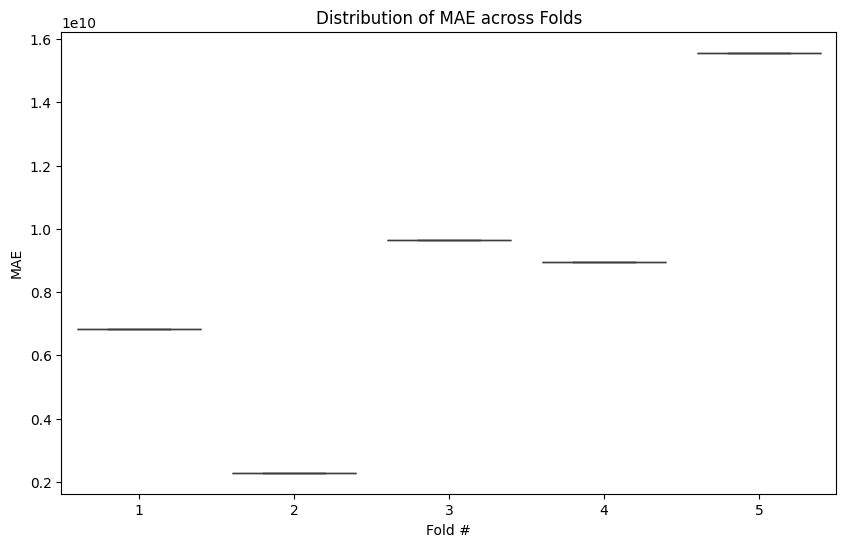

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=fold_metrics_df, x='Fold #', y='MAE')
plt.title('Distribution of MAE across Folds')
plt.show()

Issue: This could be due to outliers, different scales, or variations in the data across folds

#### Check #1:  Data Leakage

In [ ]:
def check_data_leakage(train_indices, val_indices, original_sequences):
    train_sequences = [original_sequences[idx] for idx in train_indices]
    val_sequences = [original_sequences[idx] for idx in val_indices]
    overlap = set(train_sequences).intersection(set(val_sequences))
    if overlap:
        print("Data leakage detected! Overlapping sequences:", overlap)
    else:
        print("No data leakage detected.")

for train_fold_idx, val_idx in folds:
    check_data_leakage(train_fold_idx, val_idx, sequences)

No data leakage detected.
No data leakage detected.
No data leakage detected.
No data leakage detected.
No data leakage detected.


##### Solution: 1. Identify and Remove Overlapping Seqs

In [ ]:
def remove_overlapping_sequences(train_indices, val_indices, original_sequences):
    train_sequences = set(original_sequences[idx] for idx in train_indices)
    val_sequences = set(original_sequences[idx] for idx in val_indices)
    overlap = train_sequences.intersection(val_sequences)

    if overlap:
        train_indices = [idx for idx in train_indices if original_sequences[idx] not in overlap]
        val_indices = [idx for idx in val_indices if original_sequences[idx] not in overlap]

    return train_indices, val_indices

# Applying the function within your KFold loop
for train_fold_idx, val_idx in folds:
    train_fold_idx, val_idx = remove_overlapping_sequences(train_fold_idx, val_idx, sequences)
    check_data_leakage(train_fold_idx, val_idx, sequences)


No data leakage detected.
No data leakage detected.
No data leakage detected.
No data leakage detected.
No data leakage detected.


##### Solution: 2. Ensure Separate clusters

In [ ]:
from sklearn.model_selection import StratifiedKFold
# Assuming `cluster_labels` contains the cluster IDs for each sequence
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = list(skf.split(X_train_reshaped, train_cluster_labels))

for i, (train_fold_idx, val_idx) in enumerate(folds):
    train_fold_idx, val_idx = remove_overlapping_sequences(train_fold_idx, val_idx, sequences)
    check_data_leakage(train_fold_idx, val_idx, sequences)

No data leakage detected.
No data leakage detected.
No data leakage detected.
No data leakage detected.
No data leakage detected.


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


#### Check #2:  Variability in Data
Use CV and Regularization

In [ ]:
linreg = LinearRegression()
fold_metrics = []

mae_threshold = 1e+08

# residuals = actual - predicted
residuals = []
predicted_values = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = list(skf.split(X_train_reshaped, train_cluster_labels))

for i, (train_fold_idx, val_idx) in enumerate(folds):
    train_fold_idx, val_idx = remove_overlapping_sequences(train_fold_idx, val_idx, sequences)
    check_data_leakage(train_fold_idx, val_idx, sequences)

    X_fold_train, X_fold_val = X_train_reshaped[train_fold_idx], X_train_reshaped[val_idx]
    y_fold_train, y_fold_val = y_train[train_fold_idx], y_train[val_idx]

    linreg.fit(X_fold_train, y_fold_train)
    y_pred = linreg.predict(X_fold_val)
    resid = y_fold_val - y_pred
    residuals.append(resid)
    predicted_values.append(y_pred)
    mae = mean_absolute_error(y_fold_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))
    r2 = r2_score(y_fold_val, y_pred)

    fold_metrics.append((i+1,mae, rmse, r2))

    check_aminoacylation_threshold(y_pred, y_fold_val, sequences, mae ,train_fold_idx, val_idx, folds)


fold_metrics_df = pd.DataFrame(fold_metrics, columns=['Fold #', 'MAE', 'RMSE', 'R2'])
fold_metrics_df

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Predicted Value: [0.81494141], Actual Value: [0.75362319]
Validation Sequence: CCTTCGGTAGCTCAGCGGTAGAGCGGAGGACTGTAGATCCTTAGGTCGCTGGTTCAAATCCGGCTCGAAGGACCA
Validation Sequence Index: 444
Predicted Value: [0.72705078], Actual Value: [0.57446809]
Validation Sequence: AGCAGAGTGGCGCAGCGGAAGCGTGCTGGGCCCATAACCCAGAGGACGATGGATCGAAACCATCCTCTGCTACCA
Validation Sequence Index: 451
Predicted Value: [0.21630859], Actual Value: [0.2276176]
Validation Sequence: GACACTGTGGCTTAGTTGGTTATAGCACCTGTCTAGTAAACAGGAGAGCCTGGGTTCAAATCCCAGCAGTGCCTCCA
Validation Sequence Index: 453
Predicted Value: [0.49267578], Actual Value: [0.57142857]
Validation Sequence: CCTTCGATAACTCAGTTGGTAGAGTGGAGGACTGTAGATCCTTAGGTCGCTGGTTCAAATCCGGCTCGAAGGACCA
Validation Sequence Index: 461
Predicted Value: [1.03857422], Actual Value: [1.]
Validation Sequence: TCCCATATGGTCTAGAGGTCAGGATTCCTGGTTTTCACCCAGGCGGCCCGGGTTCAATTCCCGGTATGGGAACCA
Validation Sequence Index: 463
Predicted Value: [0.29370

,Fold #,MAE,RMSE,R2
0,1,1.291768e+09,1.054724e+10,-1.172030e+21
1,2,6.246522e+09,6.509321e+10,-4.490225e+22
2,3,2.335632e+10,1.884985e+11,-3.771466e+23
3,4,4.567178e+09,4.555746e+10,-2.178163e+22
4,5,3.861183e+09,5.446869e+10,-3.089662e+22


#### Check #3: LinReg Assumption - Homoscedasticity

Breusch-Pagan Test results:
{'Lagrange multiplier statistic': 828.2818569031784, 'p-value': 3.8300837624520675e-182, 'f-value': 4908.9034171244775, 'f p-value': 0.0}

White Test results:
{'Test Statistic': 996.0, 'Test Statistic p-value': 1.3296074960514334e-218, 'F-Statistic': 1.4658818854228919e+28, 'F-Statistic p-value': 0.0}


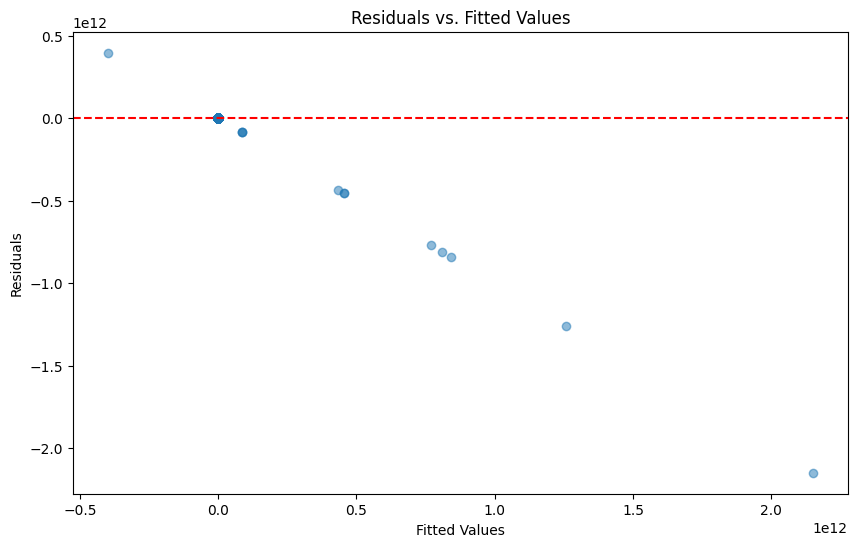

In [ ]:
flat_residuals = np.concatenate(residuals)
flat_predicted_values = np.concatenate(predicted_values)

df = pd.DataFrame({'Fitted': flat_predicted_values.ravel(), 'Residuals': flat_residuals.ravel()})

X_with_constant = sm.add_constant(df['Fitted'])

bp_test = het_breuschpagan(df['Residuals'], X_with_constant)
bp_test_results = dict(zip(['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'], bp_test))
print("Breusch-Pagan Test results:")
print(bp_test_results)

white_test = het_white(df['Residuals'], X_with_constant)
white_test_results = dict(zip(['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Statistic p-value'], white_test))
print("\nWhite Test results:")
print(white_test_results)

plt.figure(figsize=(10, 6))
plt.scatter(df['Fitted'], df['Residuals'], alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

1. Breusch-Pagan Test:

- The very low p-values (much less than 0.05) indicate that we reject the null hypothesis of homoscedasticity. This suggests that there is heteroscedasticity in the residuals.
The large Lagrange multiplier and f-statistics further support this conclusion.
2. White Test:

- Similarly, the extremely low p-values indicate rejection of the null hypothesis of homoscedasticity, implying heteroscedasticity.
The very high test statistics further confirm the presence of heteroscedasticity.

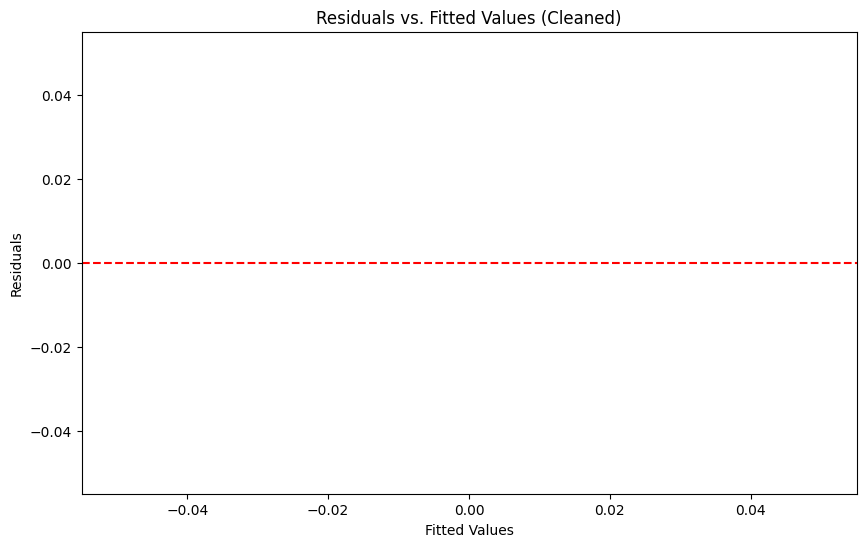

In [ ]:
z_scores = np.abs(stats.zscore(df[['Fitted', 'Residuals']]))

df_clean = df[(z_scores < 0.05).all(axis=1)]

plt.figure(figsize=(10, 6))
plt.scatter(df_clean['Fitted'], df_clean['Residuals'], alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values (Cleaned)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

The updated plot still shows outliers - homoscedasticity (constant variance of residuals) might be violated

### Baseline Model Training using All Models

In [ ]:
# Train and evaluate models
metrics = []
models = {
    'LineReg': LinearRegression(),
    'LassoCV': LassoCV(cv=5),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, tree_method='gpu_hist')  # Enable GPU
}

# Initialize a list to store detailed metrics for each fold
detailed_metrics = []

for model_name, model in models.items():
    fold_metrics = []
    all_distances = []

    for i, (train_fold_idx, val_idx) in enumerate(folds):
        X_fold_train, X_fold_val = X_train_reshaped[train_fold_idx], X_train_reshaped[val_idx]
        y_fold_train, y_fold_val = y_train[train_fold_idx], y_train[val_idx]

        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)
        mae = mean_absolute_error(y_fold_val, y_pred)

        # Check threshold
        check_aminoacylation_threshold(y_pred, y_fold_val, sequences, mae ,train_fold_idx, val_idx, i + 1)

        # Reverse transform validation and training sequences
        val_sequences = reverse_transform(X_fold_val)
        train_sequences = reverse_transform(X_fold_train)

        print(f"Calculating distances for {model_name}")

        fold_distances = []
        for j, val_seq in enumerate(val_sequences):
            most_similar_seq, min_distance = find_most_similar_sequence(val_seq, train_sequences)
            print(f"Validation Sequence Index: {val_idx[j]}")
            print(f"Validation Sequence: {val_seq}")
            print(f"Most Similar Training Sequence: {most_similar_seq}")
            print(f"Levenshtein Distance: {min_distance}")
            print("")

            # Collect all distances for later analysis
            distances = [distance(val_seq, train_seq) for train_seq in train_sequences]
            fold_distances.append({
                'Validation Index': val_idx[j],
                'Model': model_name,
                'Fold': i,
                'Min Distance': min_distance,
                'Mean Distance': np.mean(distances)
            })

        all_distances.extend(fold_distances)
        fold_metrics.append((mae, np.mean([d['Min Distance'] for d in fold_distances])))

    # Average metrics across folds
    avg_metrics = np.mean(fold_metrics, axis=0)
    metrics.append((model_name, avg_metrics[0], avg_metrics[1]))
    detailed_metrics.extend(all_distances)

detailed_df = pd.DataFrame(detailed_metrics)

metrics_df = pd.DataFrame(metrics, columns=['Model', 'Mean Absolute Error (MAE)', 'Mean Levenshtein Distance'])
print(f'Average Metrics across all {len(folds)} folds')
print(metrics_df)

#print(detailed_df.head())


# Predict on the test set with Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train_reshaped, y_train)  # Train the model on the entire training data

# Predict on the test set
lr_preds = linear_reg.predict(X_test_reshaped)

print("Linear Regression Test Set Predictions: ", lr_preds)

Streaming output truncated to the last 5000 lines.
Levenshtein Distance: 19

Validation Sequence Index: 942
Validation Sequence: GCCTCGTTAGCGCAGTAGGCAGCGCGTCAGTCTCATAATCTGAAGGTCGTGAGTTCGAGCCTCACACGGGGCACCA
Most Similar Training Sequence: GCCTCGTTGGCGCAGTAGGCAGCGCGTCAGTCTCATAATCTGAAGGTCGTGAGTTCGAGCCTCACACGGGGCACCA
Levenshtein Distance: 1

Validation Sequence Index: 944
Validation Sequence: GTGCCTGTAGCTCAACGGATAGAGCGCTGGACTCCGGATCCAGAGGTTGCGGGTTCGAGTCCCGCCAGGCACACCA
Most Similar Training Sequence: GCGCCCGTAGCTCAACTGGATAGAGCGTCGGACTTCGGATCCGATGGTTGCGGGTTCGAGTCCTGCCGGGCGCGCCA
Levenshtein Distance: 12

Validation Sequence Index: 957
Validation Sequence: GGCCCAGTGGCCTAATGGATAAGGTATCAGCCTCCGGAGCTGGGGATTGTGGGTTCAAGTCCCACCTGGGTCGCCA
Most Similar Training Sequence: CCCCCAGTGGCCTAATGGATAAGGCATTGGCCTCCTAAGCCAGGGATTGTGGGTTCGAGTCCCATCTGGGGTGCCA
Levenshtein Distance: 13

Validation Sequence Index: 971
Validation Sequence: CGCGGAGTGGAGCAGTGGTAGCTCGTTGGGCTCATAACCCAAAGGTCGTAAGTTCGAGTCTTGCCTCCGCAACCA
Mos

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008291329418376847, tolerance: 0.006098118191299837
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011523282524391831, tolerance: 0.006098118191299837
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011577661672577122, tolerance: 0.006098118191299837
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:6

Predictions out of range [0, 1] detected in Fold 1
Validation Sequence Index: 244
Predicted Value: 1.0012829759288835, Actual Value: [0.93508772]
Validation Sequence: GCCTCAGTGGCTCAGCCGGCAGAGCGCGTCCTTGGTAAGGACGAGGTCGCGAGTTCAAATCTCGCCTGAGGCTCCA
Validation Sequence Index: 266
Predicted Value: 1.1499033429825594, Actual Value: [1.]
Validation Sequence: GGGCCCGTAGCCTAGCCAGGATAGGGCATCAGACTCCTAATCTGAAGGTCCCGGGTTCAAATCCCGGCGGGTCCGCCA
Calculating distances for LassoCV
Validation Sequence Index: 10
Validation Sequence: CCTTTGATAGCTCAATTGGCAGAGCAGCAGAGTGTAGGTCCTTAGGTCGCTGGTTCAAATCCGGCTCGAAGGACCA
Most Similar Training Sequence: CCTTCGATAGCTCAGTTGGTAGAGCGGAGGACTGTAGATCCTTAGGTCGCTGGTTCAAATCCGGCTCGAAGGACCA
Levenshtein Distance: 8

Validation Sequence Index: 23
Validation Sequence: GGCCCTATAGCTCAGGGGTTAGAGCACTGGTCTTGTAAACCAGGGGTCGCGAGTTCAAATCTCGCTGGGGCCTCCA
Most Similar Training Sequence: GGCTCATAGCTCAGGGGTTAGAGCACTGGTCTTGTAAACCAGGGGTCGCGAGTTCAAATCTCGCTGGGGCCTCCA
Levenshtein Distance: 2

Validation S

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015876427102575974, tolerance: 0.006270083343850587
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021185966080487617, tolerance: 0.006270083343850587
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023689927494391583, tolerance: 0.006270083343850587
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:6

Predictions out of range [0, 1] detected in Fold 2
Validation Sequence Index: 97
Predicted Value: 1.054057912436575, Actual Value: [0.98159509]
Validation Sequence: GGCTTGTTAGTTTAGTGGCAAAACGGTTGATTCGTAATCAACTGACGCGAGTTCGATTCTCGCACAAGCCTCCA
Validation Sequence Index: 238
Predicted Value: 1.1311764385383112, Actual Value: [1.]
Validation Sequence: GCCTCGTTGGCTCAGCCCGGTAGAGCGAGTGACTTGTAATCACTAGGTCGCGTGTTCGAATCACGCACGAGGCTCCA
Validation Sequence Index: 300
Predicted Value: -0.01063778981004021, Actual Value: [0.44]
Validation Sequence: GCTCCAGTGGCGCAATCGGTTAGCGCGCGGTACTTATAATGCCGAGGTTGTGAGTTCAAGCCTCACCTGGAGCACCA
Validation Sequence Index: 424
Predicted Value: -0.04784849526063689, Actual Value: [0.12838516]
Validation Sequence: GCCTCGTTGGCGCAGTAGGCAGCGCGTCAGTCTCATAATCTGAAGGTCGTGAGTTCGAGCCTCACACGGGGCACCA
Validation Sequence Index: 575
Predicted Value: 1.0102524304911378, Actual Value: [1.]
Validation Sequence: GGGGCCTTAGCTCAGCTGGGAGAGCGCCTGCCTTGCACGCAGGAGGTCAGCGGTTCGATCCCGCTAGGCTCCACCA
Vali

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013869844825624256, tolerance: 0.006000509424331253
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01307240728989889, tolerance: 0.006000509424331253
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011434673569688414, tolerance: 0.006000509424331253
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:68

Predictions out of range [0, 1] detected in Fold 3
Validation Sequence Index: 18
Predicted Value: 1.0938782840939998, Actual Value: [0.97297297]
Validation Sequence: GCGTTCGTGGTGTAATGGTCAGCATGGATGCCTTCCAAGCATTCGACGGGGGTTCGATTCCCCTCGAACGCACCA
Validation Sequence Index: 188
Predicted Value: 1.0201660215085488, Actual Value: [1.]
Validation Sequence: GGCCCTATAGCTCAGGGGTTAGAGCACTGGTCTTGTAAACCAGGGGTCGCGAGTTCAAATCTCGCTGGGGCCTCCA
Validation Sequence Index: 203
Predicted Value: 1.1349244835861847, Actual Value: [1.]
Validation Sequence: GGCCGGTGTAGGGTAGTGGTTATCCTGAAGGACTGTGGATCCTTCGACCCGGGTTCGATTCTCGGCACCGGCCCCA
Validation Sequence Index: 223
Predicted Value: 1.0563316627362607, Actual Value: [1.]
Validation Sequence: GTCAGAATGGCAGAGTGGCTATGCTTCCGGCTGCAACCCGGAATTACGTGAGTTCGATTCTCACTTCTGACTCCA
Validation Sequence Index: 248
Predicted Value: 1.0741433999514296, Actual Value: [0.89090909]
Validation Sequence: GCCTTAGTGGCTCAGGTGGTAGAGCGATGCCTTGGTAAGGCATAGGTCGGGGGTTCGAATCCCCCCTAAGGCTCCA
Validation 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007463427601422268, tolerance: 0.005943108105304978
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010919211467779633, tolerance: 0.005943108105304978
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01100522853346142, tolerance: 0.005943108105304978
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:68

Predictions out of range [0, 1] detected in Fold 4
Validation Sequence Index: 17
Predicted Value: 1.0360989432301992, Actual Value: [0.92814371]
Validation Sequence: GGGTCCATAGCTCAGTGATAGAGCAATTGACTGCAGATCAATAGGTCACCGGTTCGAACCCGGTTGGGCCCCCA
Validation Sequence Index: 322
Predicted Value: 1.0596908107641847, Actual Value: [1.]
Validation Sequence: GTTTCCGTGGTGTAGTGGTTATCACGTTCGCCTCACACGCGAAAGGTCCCCGGTTCGAAACCGGGCGGAAACACCA
Validation Sequence Index: 503
Predicted Value: 1.148419708361244, Actual Value: [1.]
Validation Sequence: GCCGTGGTAGCTCAGTTGGGAGAGCGCCAGACTGAAGATCTGGAGGTCGCTGGTTCGATCCCGGCCCACGGCACCA
Validation Sequence Index: 676
Predicted Value: -0.04934343956646048, Actual Value: [0.31578947]
Validation Sequence: GTCCTCGTAGCTCAGCAGGATAGAGCGGTTGCCTCCTAAGCAGCAGGCCATGCGTTCGAATCGCATCGAGGACCCA
Validation Sequence Index: 691
Predicted Value: 1.0002351335657411, Actual Value: [0.93220339]
Validation Sequence: GCACCGATAGCTCAATGGATAGAGTACCCGGCTTCGAACCGGGTGGTTAGAGGTTCGAGCCCTCTTCGGTGCACCA
Va

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006395516108511856, tolerance: 0.006081350468990862
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007167518020064989, tolerance: 0.006081350468990862
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008843069153154914, tolerance: 0.006081350468990862
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:6

Predictions out of range [0, 1] detected in Fold 5
Validation Sequence Index: 102
Predicted Value: 1.106776543801884, Actual Value: [1.]
Validation Sequence: GGGCCAGTGGCGCAATGGATAACGCGTCTGACTACGGATCAGAAGATTGTAGGTTCGACTCCTGCCTGGCTCGCCA
Validation Sequence Index: 564
Predicted Value: 1.0037848018325715, Actual Value: [0.96296296]
Validation Sequence: GGGCCCGTAGCTCAGTTGGATAGAGCAGGGGATTTCTAATCCCCAGGTCGGGGGTTCGAGTCCCTCCGGGCCCACCA
Validation Sequence Index: 663
Predicted Value: -0.0789786919972203, Actual Value: [0.11111111]
Validation Sequence: GCCCCCATCGTCTAACGGTTAGGACACCAGACTTTCAATCTGACAACGAGAGTTCGACTCTCTCTGGGGGTACCA
Validation Sequence Index: 702
Predicted Value: 1.106746898796835, Actual Value: [0.74418605]
Validation Sequence: GCGTCTTTAGCTCAGCTGGATAGAGCAACGGCCTTCTAAGCCGTGTGCCAGGGGTTCGACTCCCTTAAGACGCACCA
Validation Sequence Index: 804
Predicted Value: 1.0307436453411163, Actual Value: [0.96202532]
Validation Sequence: CGGAATATAGCGCAGCCCGGTAGCGCACCTGCCTTGGGAGCAGGGGGCCGCAAGTTCAAATCTTGCTAT

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:04:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:04:27] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Calculating distances for XGBoost
Validation Sequence Index: 10
Validation Sequence: CCTTTGATAGCTCAATTGGCAGAGCAGCAGAGTGTAGGTCCTTAGGTCGCTGGTTCAAATCCGGCTCGAAGGACCA
Most Similar Training Sequence: CCTTCGATAGCTCAGTTGGTAGAGCGGAGGACTGTAGATCCTTAGGTCGCTGGTTCAAATCCGGCTCGAAGGACCA
Levenshtein Distance: 8

Validation Sequence Index: 23
Validation Sequence: GGCCCTATAGCTCAGGGGTTAGAGCACTGGTCTTGTAAACCAGGGGTCGCGAGTTCAAATCTCGCTGGGGCCTCCA
Most Similar Training Sequence: GGCTCATAGCTCAGGGGTTAGAGCACTGGTCTTGTAAACCAGGGGTCGCGAGTTCAAATCTCGCTGGGGCCTCCA
Levenshtein Distance: 2

Validation Sequence Index: 25
Validation Sequence: GCGTCATTAGCTCAGTTGGTAGAGCACACGACTTTTAATCGTGTTGTCACAAGTTCAAATCTTGTATGACGCACCA
Most Similar Training Sequence: GCGTTATTAGCTCAGTTGGTAGAGCACCTGACTCTTAATCAGGGTGCCCAGGGTTCGAATCCCTGATGACGCACCA
Levenshtein Distance: 15

Validation Sequence Index: 29
Validation Sequence: CGCGGGGTGGAGCAGCTGGTAGCTCGTCGGGCTCATAACCCGAAGGTCGTAGGTTCAAGTCCTACCTCCGCAACCA
Most Similar Training Sequence: CGCGGGGTGGAGCAGTCTGG

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:04:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Predictions out of range [0, 1] detected in Fold 2
Validation Sequence Index: 692
Predicted Value: 1.0458283424377441, Actual Value: [1.]
Validation Sequence: CGGGACGTGGCGCAGTTTGGTAGCGCACCTGCTTTGGGAGCAGGGGGTCGCAGGTTCAAATCCTGTCGTCCCGACCA
Calculating distances for XGBoost
Validation Sequence Index: 0
Validation Sequence: GCCAACTTAGCTCACCTGGCAGAGCAGCACCCTCGTAACGTGCAGGTACCCGGTTCGAGCCCGGGAGTTGGCTCCA
Most Similar Training Sequence: GCCGATTTAGCTCAGCTGGTAGAGCAACGCACTCGTAACGCGTAGGTCACAGGTTCAAGTCCTGCAATCGGCACCA
Levenshtein Distance: 19

Validation Sequence Index: 2
Validation Sequence: GGGCCGGTAGTCTAGCGGAAGGATGCCCGCCTCGCGCGCGGGAGATCCCGGGTTCGAATCCCGGCCGGTCCACCA
Most Similar Training Sequence: GGGCCGGTAGTCTAGCGGAAGGATGCCCGCCTTGCACGCGGGTGATCCCGGGTTCGAATCCCGGCCGGTCCACCA
Levenshtein Distance: 3

Validation Sequence Index: 5
Validation Sequence: ATCAGAGTGGCGCAGCGGAAGCGTGGTGGGCCCATAACCCACAGGTCCCAAGATCGAAACTTGGCTCTGATACCA
Most Similar Training Sequence: AGCAGAGTGGCGCAGTGGAAGCGTGCTGGTCCCATAACCCAGAGGTCCGA

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:04:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Predictions out of range [0, 1] detected in Fold 3
Validation Sequence Index: 872
Predicted Value: 1.005913257598877, Actual Value: [1.]
Validation Sequence: GGGGCCGTAGCTCAGCTGGGAGAGCACCTGCTTTGCAAGCAGGGGGTCGTCGGTTCGATCCCGTCCGGCTCCACCA
Validation Sequence Index: 936
Predicted Value: 1.01849365234375, Actual Value: [0.98181818]
Validation Sequence: CGCGGAGTGGAGCAGTGGTAGCTCGTTGGGCTCATAACCCAAAGGTCGTAAGTTCGAGTCTTGCCTCCGCAACCA
Calculating distances for XGBoost
Validation Sequence Index: 3
Validation Sequence: GCTCCTGTAGCTCAGTCGGCAGAGCACAACCATGGTAAGGTTGGGGTCAGCAGTTCAATTCTGCTCGGGAGCTCCA
Most Similar Training Sequence: GCCCCGGTAGCTCAGTGGCAGAGCACTTCCATGGTAAGGAAGGGGTCGTCAGTTCAATCCTGACCCGGGGCTCCA
Levenshtein Distance: 13

Validation Sequence Index: 11
Validation Sequence: GCATTGGTGATTCAGTGGTAGAATTCTCGCCTGCCACGCGGGGGGCCCGGGTTCGATTCCCGGCCAATGCACCA
Most Similar Training Sequence: GCATTGGTGGTTCAGTGGTAGAATTCTCTCCTGCCACGCGGGAGGCCCGGGTTCGATTCCCGGCCAATGCACCA
Levenshtein Distance: 3

Validation Sequence In

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:04:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:04:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Predictions out of range [0, 1] detected in Fold 4
Validation Sequence Index: 322
Predicted Value: 1.0175089836120605, Actual Value: [1.]
Validation Sequence: GTTTCCGTGGTGTAGTGGTTATCACGTTCGCCTCACACGCGAAAGGTCCCCGGTTCGAAACCGGGCGGAAACACCA
Calculating distances for XGBoost
Validation Sequence Index: 8
Validation Sequence: GTCAGGATAGCTCAGTTGGTAGAGCAGAGGACTGAAAATCCTCGTGTCACCAGTTCAAATCTGGTTCCTGGCACCA
Most Similar Training Sequence: GGCCAGATAGCTCAGTCGGTAGAGCAGAGGACTGAAAATCCTCGTGTCCCTGGTTCGATTCCTGGTCTGGCCACCA
Levenshtein Distance: 13

Validation Sequence Index: 16
Validation Sequence: GGTGGAATGGCCGAGTGGTGAGGCAACGGTCTGCAAAACCGTGCACACGGGTTCGATTCCCGTTTCCACCTCCA
Most Similar Training Sequence: GGTGGAGTGGCCGAGTGGTGAGGCAACGGCCTGCAAAGCCGTGCACACGGGTTCGATTCCCGTCTCCACCTCCA
Levenshtein Distance: 4

Validation Sequence Index: 17
Validation Sequence: GGTCGCATAGCTCAGTTGGGAGAGCACCTGCCTTACAAGCAGGGGGTCATAGGTTCAAGTCCTATTGCGACCACCA
Most Similar Training Sequence: GGTCGCATAGCTCAGTTGGGAGAGCACCTGCCTTACAAGCAGGGGGTCAT

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:04:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:04:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Predictions out of range [0, 1] detected in Fold 5
Validation Sequence Index: 102
Predicted Value: 1.00636887550354, Actual Value: [1.]
Validation Sequence: GGGCCAGTGGCGCAATGGATAACGCGTCTGACTACGGATCAGAAGATTGTAGGTTCGACTCCTGCCTGGCTCGCCA
Calculating distances for XGBoost
Validation Sequence Index: 1
Validation Sequence: CCGTCGATAGCTCAGTTGGTAGAGCGGAGGACTGTAGATCCTTAGGTCGCTGGTTCGAATCCGGCTCGACGGACCA
Most Similar Training Sequence: CAGTCGATAGCTCAGTTGGTAGAGCGGAGGACTGTAGATCCTTAGGTCGCTGGTTCGAATCCGGCTCGACGGACCA
Levenshtein Distance: 1

Validation Sequence Index: 4
Validation Sequence: GGGGATGTAGCTCAATGGTAGAGCCTCAGTCTTCCAAACTGATTACGCGGGTTCGATTCCCGTCATCCCCTCCA
Most Similar Training Sequence: GCGGGTGTAGCTCAATGGTAGAGCAGCAGCCTTCCAAGCTGAATACGAGGGTTCGATTCCCTTCACCCGCTCCA
Levenshtein Distance: 11

Validation Sequence Index: 13
Validation Sequence: GGGCCCGTAGCTCAGTTGGATAGAGCAGGGGATTTCTAATCCCCAGGTCGGGGGTTCGAGTCCCTCCGGGCCCACCA
Most Similar Training Sequence: GCGCCCGTAGCTCAGCAGGATAGAGCGGGGGCTTCCTAAGCCCTAGGCCGGG

In [ ]:
detailed_df[detailed_df['Fold'] == 0]

,Validation Index,Model,Fold,Min Distance,Mean Distance
0,1,LineReg,0,2,29.169598
1,5,LineReg,0,10,37.045226
2,6,LineReg,0,3,29.486181
3,13,LineReg,0,11,28.655779
4,21,LineReg,0,15,29.238693
...,...,...,...,...,...
2187,977,XGBoost,0,2,33.795226
2188,981,XGBoost,0,22,33.850503
2189,987,XGBoost,0,13,28.680905
2190,990,XGBoost,0,4,36.846734


#### Distance Metrics Analysis

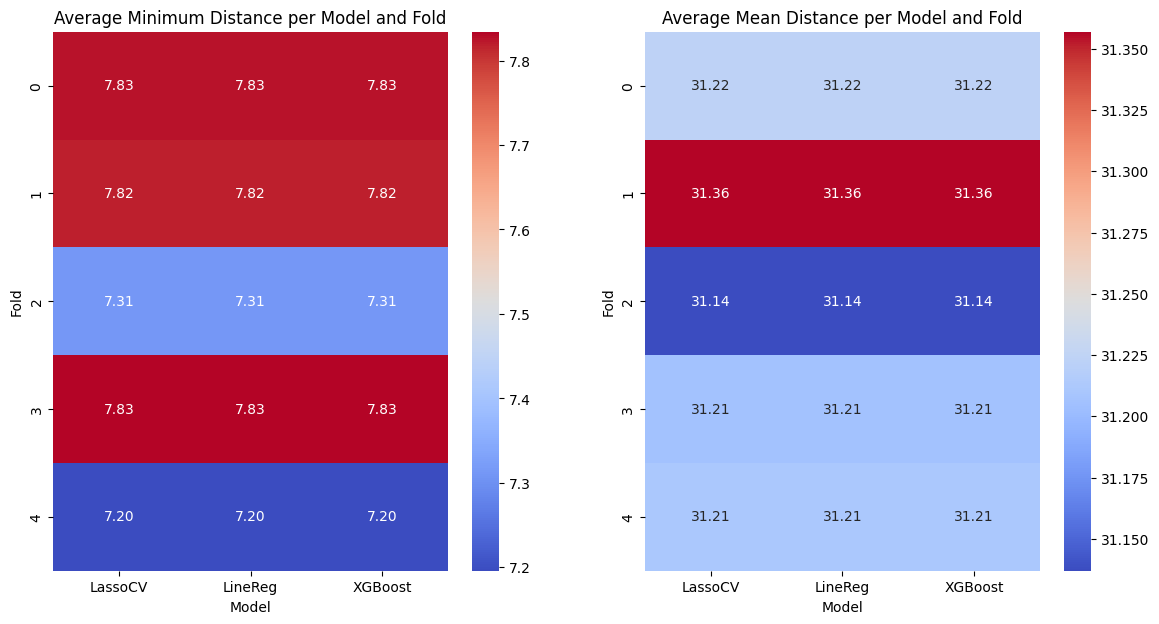

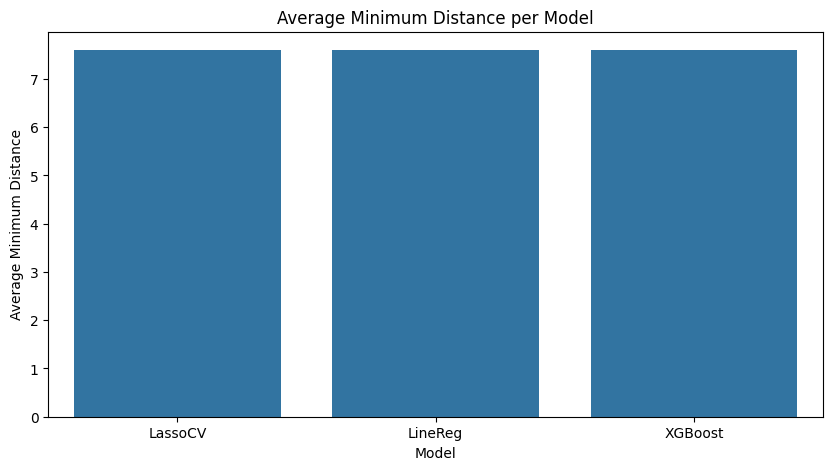

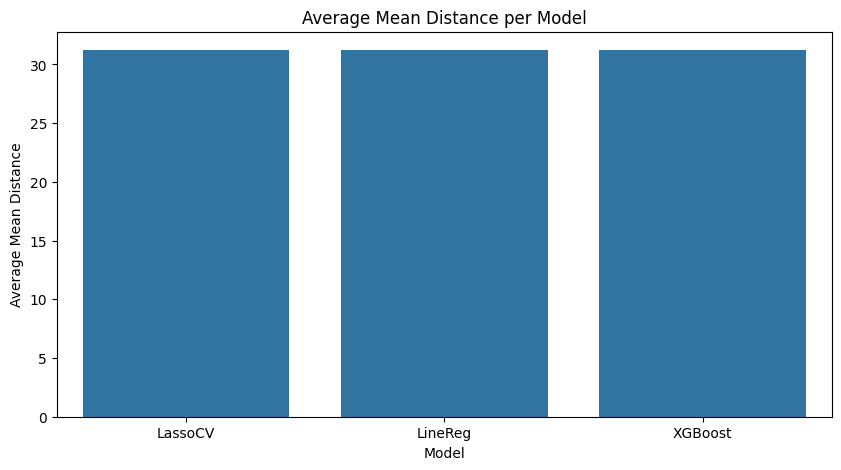

Outliers Description
       Validation Index       Fold  Min Distance  Mean Distance  \
count         33.000000  33.000000     33.000000      33.000000   
mean         432.090909   1.272727     19.727273      38.437367   
std          220.767463   1.153059      9.298094       1.775177   
min           96.000000   0.000000      2.000000      36.179648   
25%          253.000000   0.000000      8.000000      36.552764   
50%          419.000000   1.000000     26.000000      38.306148   
75%          606.000000   2.000000     27.000000      39.687578   
max          905.000000   4.000000     28.000000      41.662060   

       Min Distance Z-Score  Mean Distance Z-Score  
count             33.000000              33.000000  
mean               2.043490               3.497383  
std                1.566426               0.861044  
min               -0.942978               2.402284  
25%                0.067827               2.583263  
50%                3.100241               3.433736  
75% 

,Validation Index,Model,Fold,Min Distance,Mean Distance,Min Distance Z-Score,Mean Distance Z-Score
19,96,LineReg,0,26,36.179648,3.100241,2.402284
121,606,LineReg,0,8,41.662060,0.067827,5.061510
181,905,LineReg,0,27,36.552764,3.268708,2.583263
250,253,LineReg,1,2,38.478043,-0.942978,3.517113
253,267,LineReg,1,26,37.500627,3.100241,3.043021
285,425,LineReg,1,26,36.317440,3.100241,2.469120
312,560,LineReg,1,28,38.141782,3.437176,3.354010
448,247,LineReg,2,15,38.833124,1.247099,3.689344
469,352,LineReg,2,27,39.687578,3.268708,4.103794
524,623,LineReg,2,24,38.306148,2.763306,3.433736


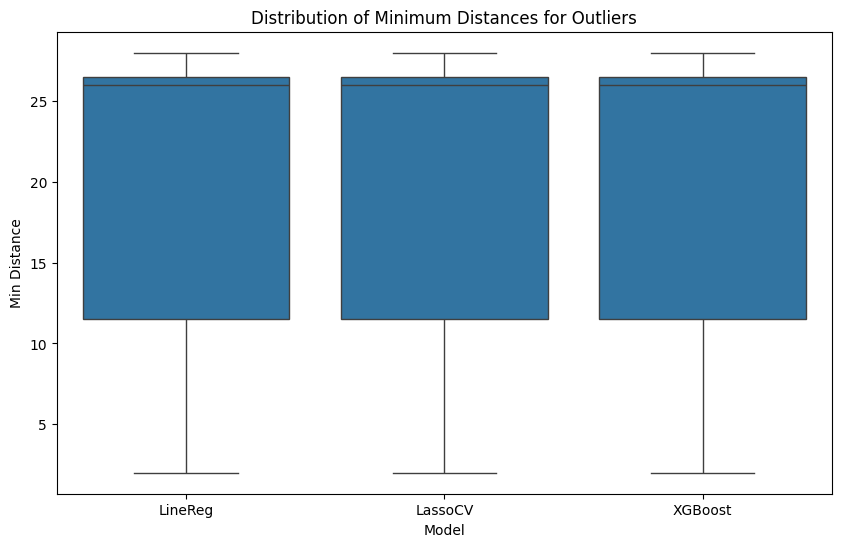

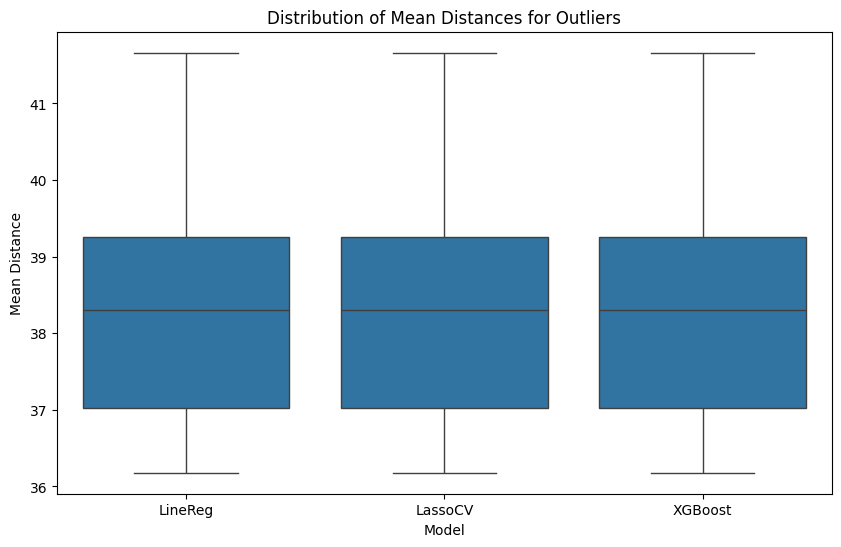

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_heatmaps(detailed_df):
    model_fold_stats = detailed_df.groupby(['Model', 'Fold']).agg({
        'Min Distance': 'mean',
        'Mean Distance': 'mean'
    }).reset_index()

    pivot_min = model_fold_stats.pivot(index="Fold", columns="Model", values="Min Distance")
    pivot_mean = model_fold_stats.pivot(index="Fold", columns="Model", values="Mean Distance")

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    sns.heatmap(pivot_min, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title('Average Minimum Distance per Model and Fold')

    plt.subplot(1, 2, 2)
    sns.heatmap(pivot_mean, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title('Average Mean Distance per Model and Fold')
    plt.show()

def plot_avg_distances(detailed_df):
    avg_distances_per_model = detailed_df.groupby('Model').agg({
        'Min Distance': 'mean',
        'Mean Distance': 'mean'
    }).reset_index()

    plt.figure(figsize=(10, 5))
    sns.barplot(data=avg_distances_per_model, x='Model', y='Min Distance')
    plt.title('Average Minimum Distance per Model')
    plt.ylabel('Average Minimum Distance')
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.barplot(data=avg_distances_per_model, x='Model', y='Mean Distance')
    plt.title('Average Mean Distance per Model')
    plt.ylabel('Average Mean Distance')
    plt.show()

from scipy.stats import zscore

def identify_and_plot_outliers(detailed_df):
    detailed_df['Min Distance Z-Score'] = detailed_df.groupby('Model')['Min Distance'].transform(zscore)
    detailed_df['Mean Distance Z-Score'] = detailed_df.groupby('Model')['Mean Distance'].transform(zscore)

    outliers = detailed_df[(detailed_df['Min Distance Z-Score'].abs() > 3) | (detailed_df['Mean Distance Z-Score'].abs() > 3)]
    outliers.to_csv('outliers.csv')

    print("Outliers Description")
    print(outliers.describe())

    high_z_scores = outliers[(outliers['Min Distance Z-Score'].abs() > 3) | (outliers['Mean Distance Z-Score'].abs() > 3)]
    display(high_z_scores)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=outliers, x='Model', y='Min Distance')
    plt.title('Distribution of Minimum Distances for Outliers')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=outliers, x='Model', y='Mean Distance')
    plt.title('Distribution of Mean Distances for Outliers')
    plt.show()

plot_heatmaps(detailed_df)
plot_avg_distances(detailed_df)
identify_and_plot_outliers(detailed_df)


### Hyperparameter Tuning + Evaluation on Test Set

In [ ]:
lasso_param_grid = {
    'alpha': [0.001]
    #'max_iter' : [10,000]
}

xgboost_param_grid = {
    'n_estimators': [300],
    'max_depth': [7],
    'learning_rate': [0.1]
}

lasso_grid = GridSearchCV(Lasso(), lasso_param_grid, cv=5, scoring='neg_mean_absolute_error')
xgboost_grid = GridSearchCV(XGBRegressor(), xgboost_param_grid, cv=5, scoring='neg_mean_absolute_error')

lasso_grid.fit(X_train_reshaped, y_train)
xgboost_grid.fit(X_train_reshaped, y_train)

best_lasso = lasso_grid.best_estimator_
best_xgboost = xgboost_grid.best_estimator_

lasso_preds = best_lasso.predict(X_test_reshaped)
xgboost_preds = best_xgboost.predict(X_test_reshaped)

lasso_mae = mean_absolute_error(y_test, lasso_preds)
xgboost_mae = mean_absolute_error(y_test, xgboost_preds)

similar_sequences = [find_most_similar_sequence(test_seq, train_sequences) for test_seq in test_sequences]

mean_levenshtein_distance = np.mean([distance for _, distance in similar_sequences])

lasso_results = pd.DataFrame({'Actual': y_test.flatten(), 'LASSO Predicted': lasso_preds.flatten()})
xgboost_results = pd.DataFrame({'Actual': y_test.flatten(), 'XGBoost Predicted': xgboost_preds.flatten()})

lasso_levenshtein_distances = [distance(train_sequences[np.argmin(np.abs(train_percentages - pred))], test_seq) for pred, test_seq in zip(lasso_preds, test_sequences)]
xgboost_levenshtein_distances = [distance(train_sequences[np.argmin(np.abs(train_percentages - pred))], test_seq) for pred, test_seq in zip(xgboost_preds, test_sequences)]

mean_levenshtein_lasso = np.mean(lasso_levenshtein_distances)
std_levenshtein_lasso = np.std(lasso_levenshtein_distances)
mean_levenshtein_xgboost = np.mean(xgboost_levenshtein_distances)
std_levenshtein_xgboost = np.std(xgboost_levenshtein_distances)

lasso_mae_values = np.abs(lasso_preds - y_test)
xgboost_mae_values = np.abs(xgboost_preds - y_test)
lasso_mae_values

print("Best LassoCV Parameters:", lasso_grid.best_params_)
print("Best XGBoost Parameters:", xgboost_grid.best_params_)
print("LassoCV Test MAE:", lasso_mae)
print("XGBoost Test MAE:", xgboost_mae)
print("Mean Levenshtein Distance:", mean_levenshtein_distance)

lasso_results, xgboost_results

Best LassoCV Parameters: {'alpha': 0.001}
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
LassoCV Test MAE: 0.15628285578984868
XGBoost Test MAE: 0.09975841442933983
Mean Levenshtein Distance: 6.511811023622047


(       Actual  LASSO Predicted
 0    0.070423         0.390277
 1    0.736111         0.297637
 2    0.947368         0.820487
 3    0.444997         0.592742
 4    0.153846         0.096970
 ..        ...              ...
 249  0.886525         0.703678
 250  0.971429         0.803783
 251  0.987179         0.945446
 252  0.965517         0.782640
 253  0.952381         0.870648
 
 [254 rows x 2 columns],
        Actual  XGBoost Predicted
 0    0.070423           0.105814
 1    0.736111           0.483968
 2    0.947368           0.922382
 3    0.444997           0.439117
 4    0.153846           0.122987
 ..        ...                ...
 249  0.886525           0.736414
 250  0.971429           0.995640
 251  0.987179           0.986306
 252  0.965517           0.954904
 253  0.952381           0.983870
 
 [254 rows x 2 columns])

In [ ]:
min(lasso_levenshtein_distances)

27

In [ ]:
min(xgboost_levenshtein_distances)

27

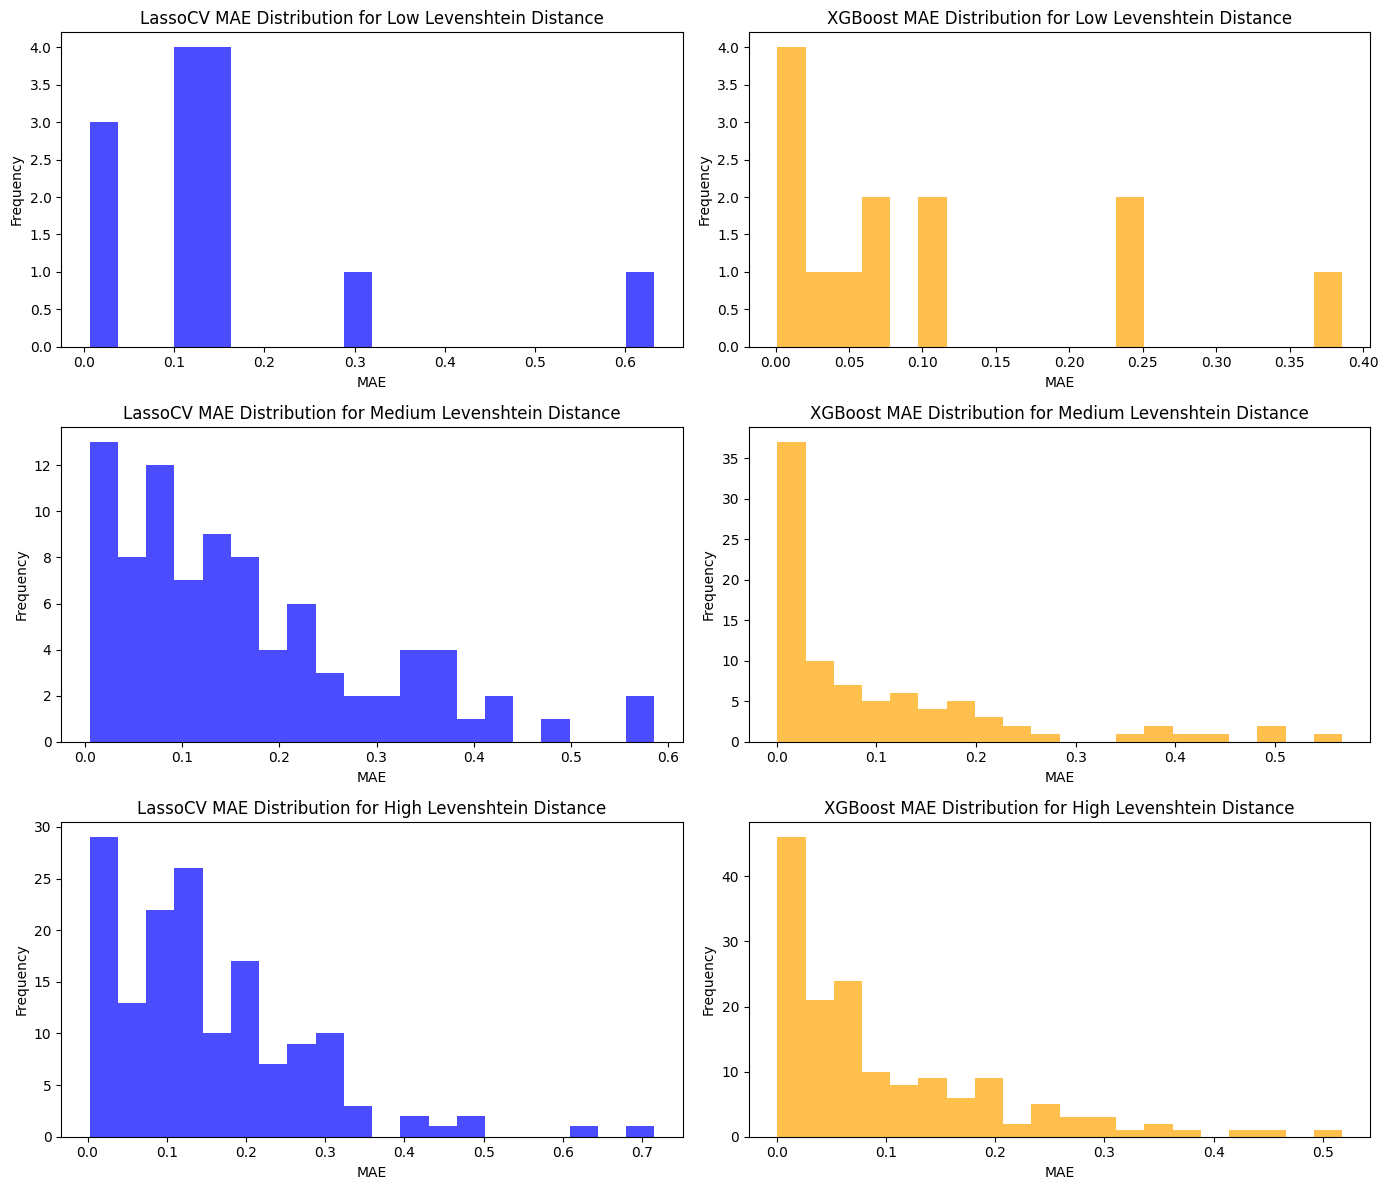

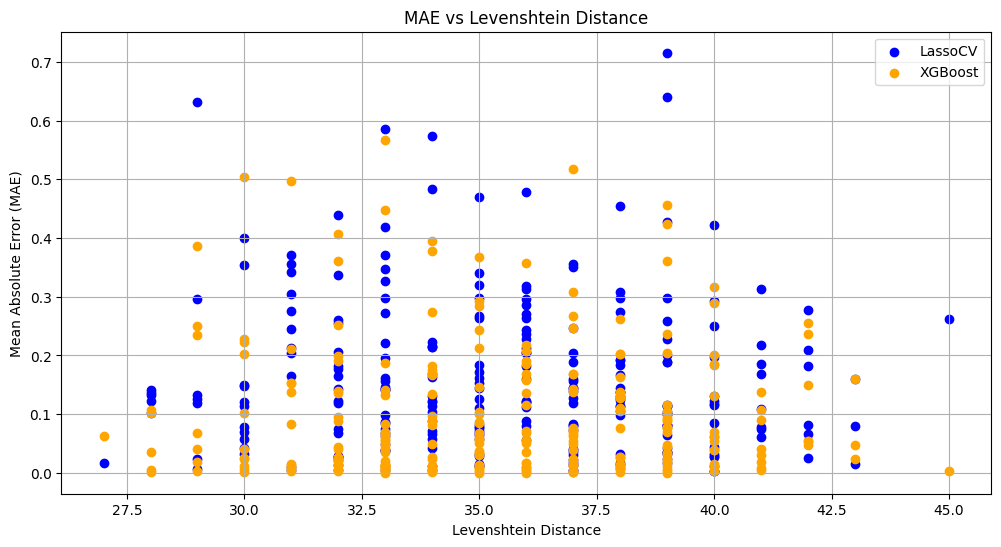

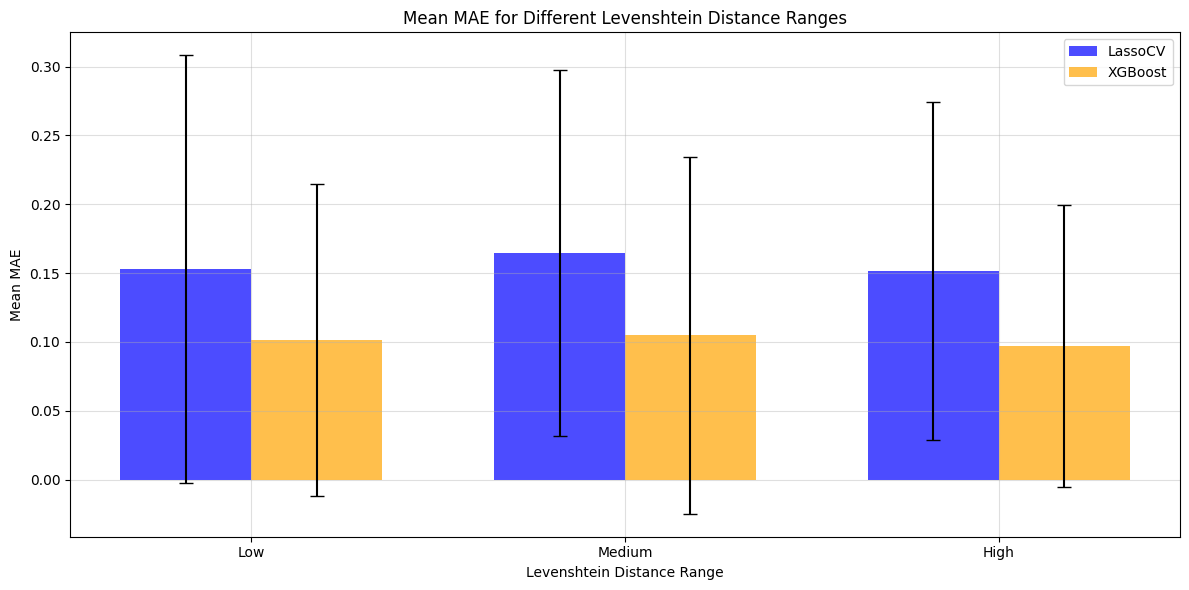

In [ ]:
def calculate_mean_std_mae(model_mae, model_levenshtein_distances, ranges):
    mean_mae = []
    std_mae = []
    labels = []

    model_levenshtein_distances = np.array(model_levenshtein_distances)

    for label, min_dist, max_dist in ranges:
        mask = (model_levenshtein_distances >= min_dist) & (model_levenshtein_distances < max_dist)
        mean_mae.append(np.mean(model_mae[mask]))
        std_mae.append(np.std(model_mae[mask]))
        labels.append(label)

    return mean_mae, std_mae, labels

ranges = [("Low", 0, 30), ("Medium", 30, 35), ("High", 35, np.inf)]

# Calculate MAE values for Lasso and XGBoost models
lasso_mae_values = np.abs(y_test.flatten() - lasso_preds.flatten())
xgboost_mae_values = np.abs(y_test.flatten() - xgboost_preds.flatten())

# Calculate mean and std MAE for Lasso and XGBoost models
lasso_mean_mae, lasso_std_mae, labels = calculate_mean_std_mae(lasso_mae_values, lasso_levenshtein_distances, ranges)
xgboost_mean_mae, xgboost_std_mae, _ = calculate_mean_std_mae(xgboost_mae_values, xgboost_levenshtein_distances, ranges)

# Subplots showing the distribution of MAE values for different Levenshtein distance ranges, separated by model
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

for i, (label, min_dist, max_dist) in enumerate(ranges):
    mask_lasso = (np.array(lasso_levenshtein_distances) >= min_dist) & (np.array(lasso_levenshtein_distances) < max_dist)
    mask_xgboost = (np.array(xgboost_levenshtein_distances) >= min_dist) & (np.array(xgboost_levenshtein_distances) < max_dist)

    axs[i, 0].hist(lasso_mae_values[mask_lasso], bins=20, color='blue', alpha=0.7)
    axs[i, 0].set_title(f'LassoCV MAE Distribution for {label} Levenshtein Distance')
    axs[i, 0].set_xlabel('MAE')
    axs[i, 0].set_ylabel('Frequency')

    axs[i, 1].hist(xgboost_mae_values[mask_xgboost], bins=20, color='orange', alpha=0.7)
    axs[i, 1].set_title(f'XGBoost MAE Distribution for {label} Levenshtein Distance')
    axs[i, 1].set_xlabel('MAE')
    axs[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Scatter plot with Min Levenshtein Distance on x axis, MAE on y axis
plt.figure(figsize=(12, 6))
plt.scatter(lasso_levenshtein_distances, lasso_mae_values, color='blue', label='LassoCV')
plt.scatter(xgboost_levenshtein_distances, xgboost_mae_values, color='orange', label='XGBoost')
plt.xlabel('Levenshtein Distance')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs Levenshtein Distance')
plt.legend()
plt.grid(":")
plt.show()

# BarPlot: Levenshtein distance on x axis, mean MAE on y axis
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(labels))
bar1 = plt.bar(index, lasso_mean_mae, bar_width, yerr=lasso_std_mae, capsize=5, label='LassoCV', color='blue', alpha=0.7)
bar2 = plt.bar(index + bar_width, xgboost_mean_mae, bar_width, yerr=xgboost_std_mae, capsize=5, label='XGBoost', color='orange', alpha=0.7)

plt.xlabel('Levenshtein Distance Range')
plt.ylabel('Mean MAE')
plt.title('Mean MAE for Different Levenshtein Distance Ranges')
plt.xticks(index + bar_width / 2, labels)
plt.legend()
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show()


### Residual Analysis - Lasso and XGBoost

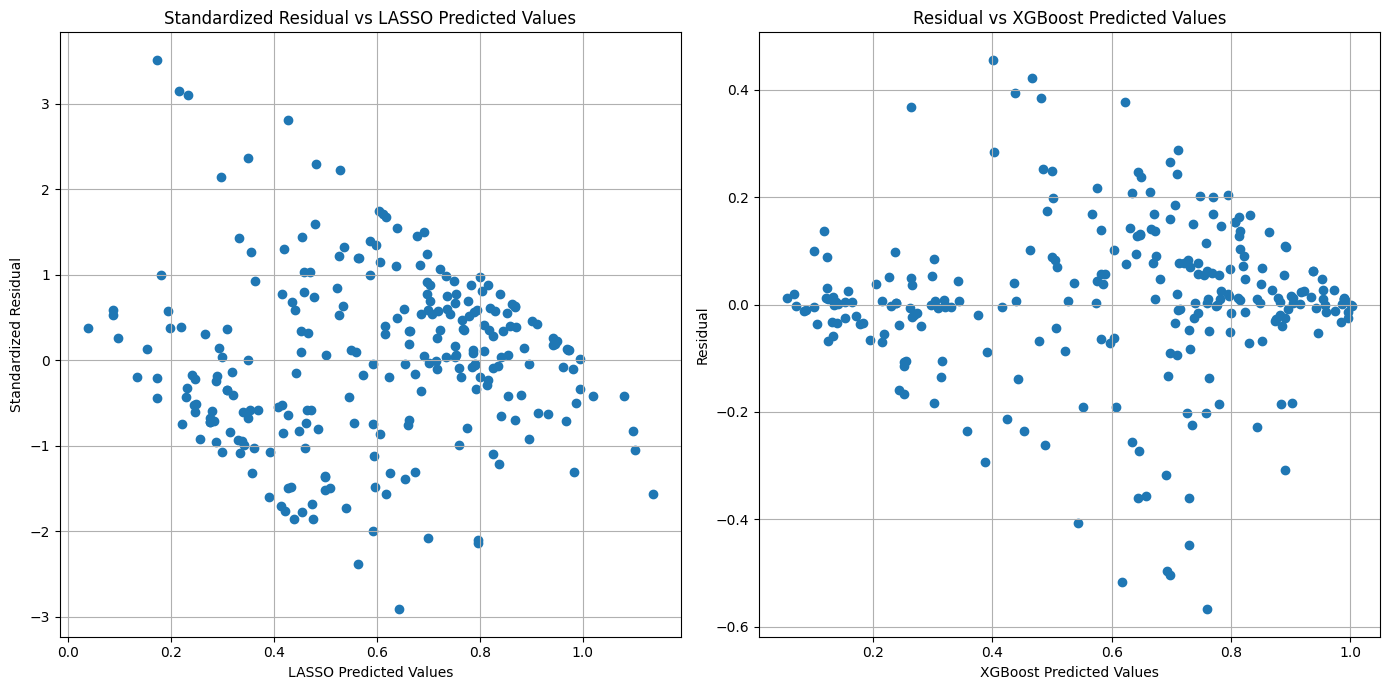

In [ ]:
def plot_residuals(y_test, lasso_results, xgboost_results):
    # Calculate residuals for LASSO
    residual_lasso = y_test.ravel() - lasso_results['LASSO Predicted']
    residual_lasso_standardized = (residual_lasso - residual_lasso.mean()) / residual_lasso.std()

    # Plot LASSO residuals
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.scatter(lasso_results['LASSO Predicted'], residual_lasso_standardized)
    plt.xlabel("LASSO Predicted Values")
    plt.ylabel("Standardized Residual")
    plt.title("Standardized Residual vs LASSO Predicted Values")
    plt.tight_layout()
    plt.grid(":")

    # Calculate residuals for XGBoost
    residual_xgboost = y_test.ravel() - xgboost_results['XGBoost Predicted']

    # Plot XGBoost residuals
    plt.subplot(1, 2, 2)
    plt.scatter(xgboost_results['XGBoost Predicted'], residual_xgboost)
    plt.xlabel("XGBoost Predicted Values")
    plt.ylabel("Residual")
    plt.title("Residual vs XGBoost Predicted Values")
    plt.tight_layout()
    plt.grid(":")

    plt.show()
plot_residuals(y_test, lasso_results, xgboost_results)

### Overall Results

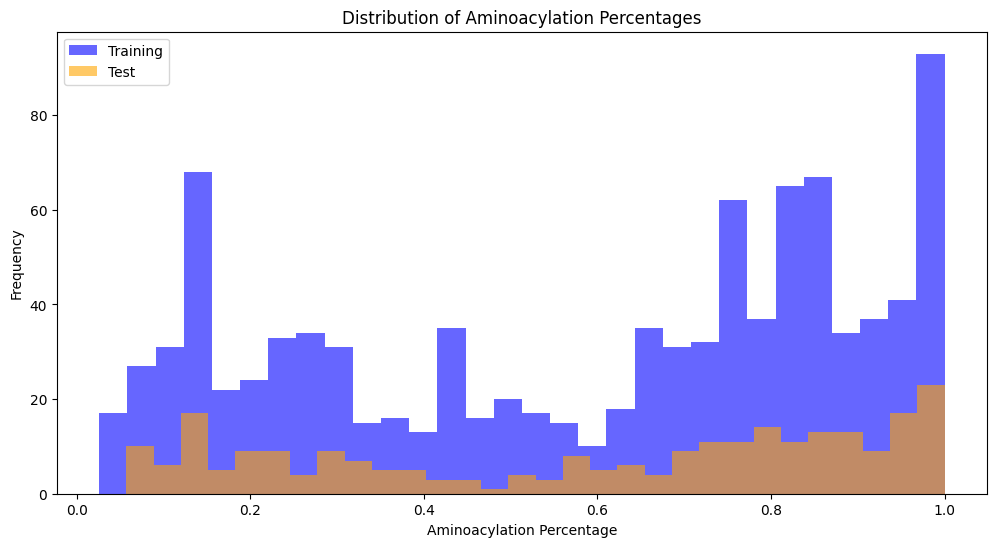

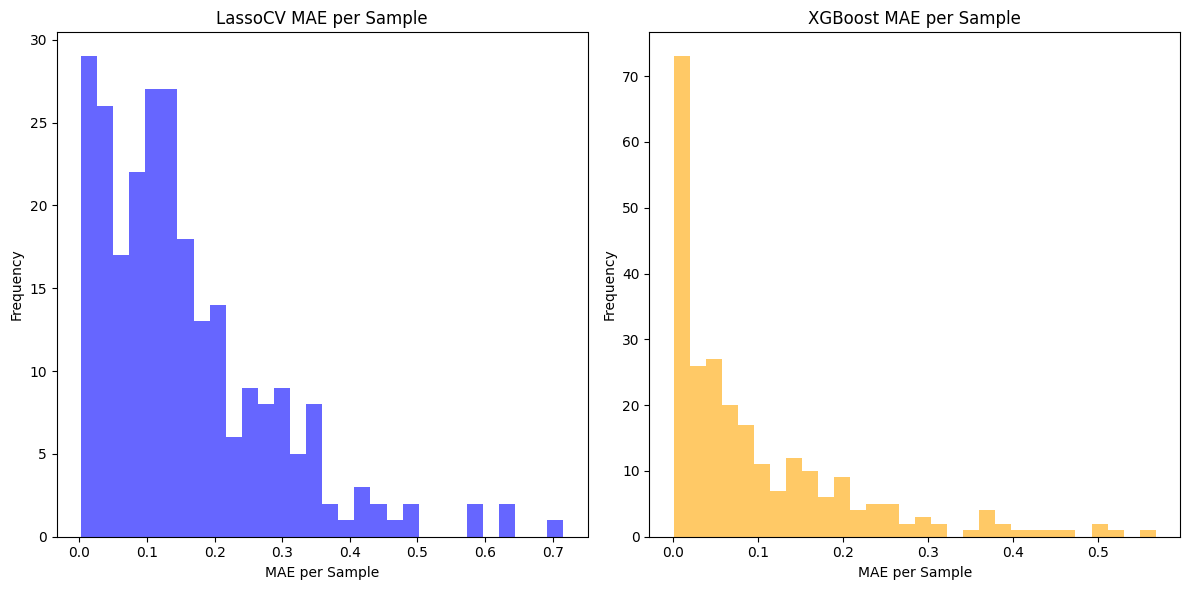

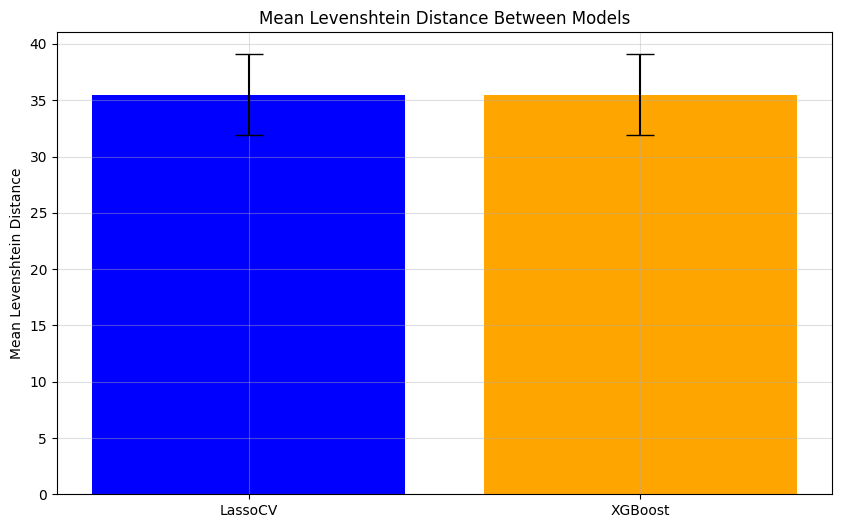

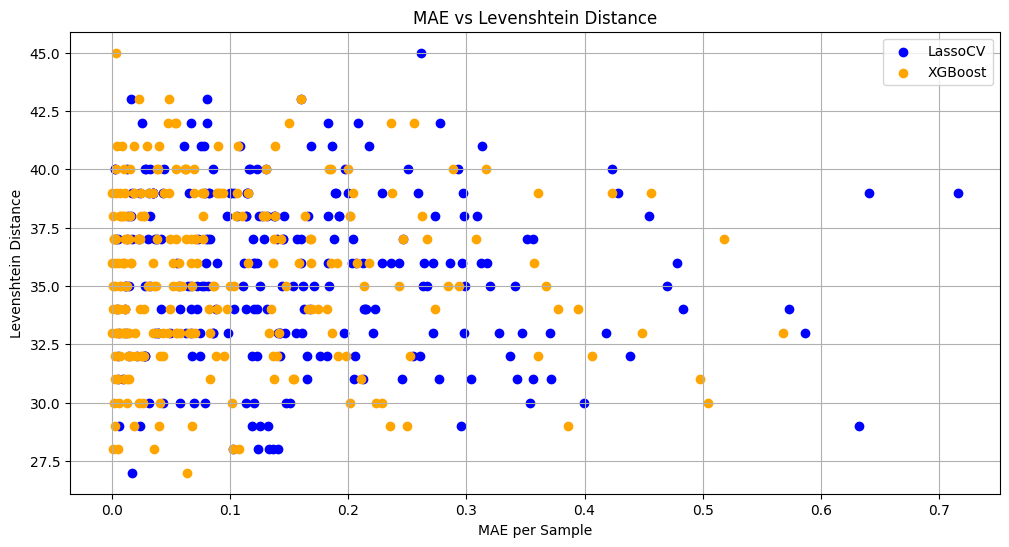

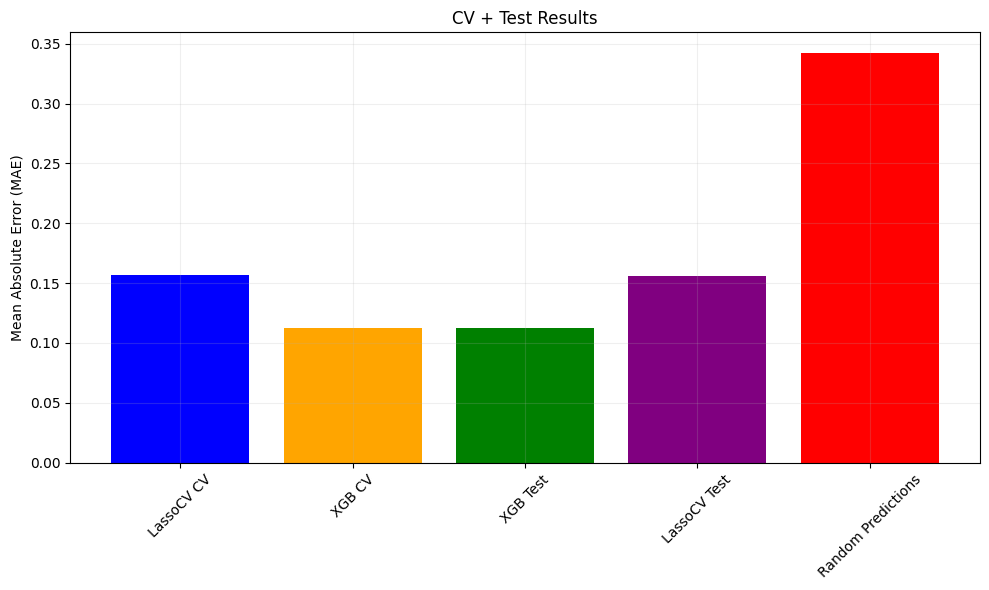

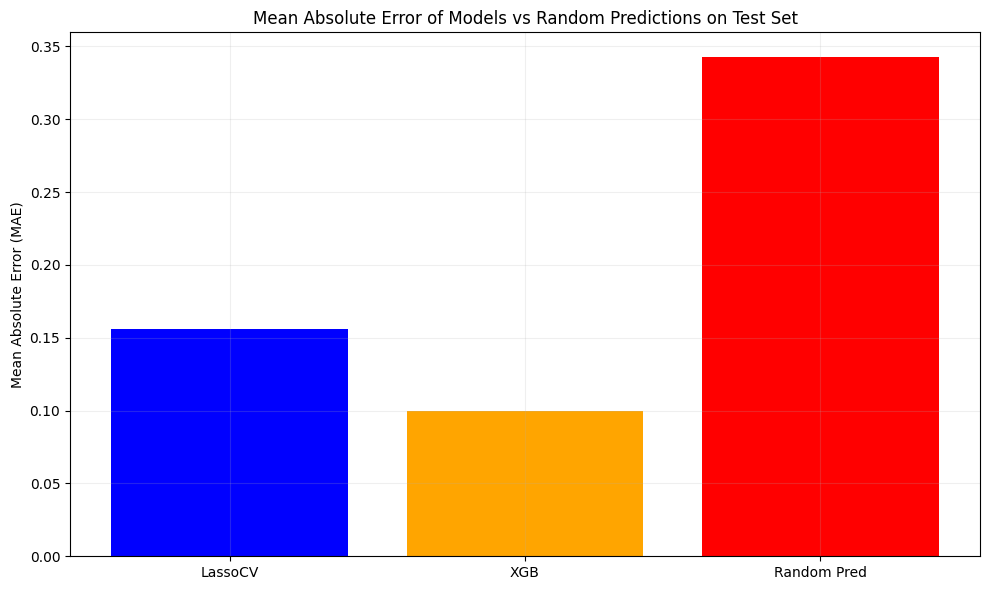

In [ ]:
def plot_model_analysis(y_train, y_test, lasso_results, xgboost_results, metrics_df,
                        mean_levenshtein_lasso, mean_levenshtein_xgboost,
                        std_levenshtein_lasso, std_levenshtein_xgboost,
                        lasso_levenshtein_distances, xgboost_levenshtein_distances):
    # Extract MAE values from the metrics dataframe
    lasso_cv_mae = metrics_df[metrics_df['Model'] == 'LassoCV']['Mean Absolute Error (MAE)'].iloc[0]
    xgb_cv_mae = metrics_df[metrics_df['Model'] == 'XGBoost']['Mean Absolute Error (MAE)'].iloc[0]

    # Plot distribution of aminoacylation percentages in training and validation sets
    plt.figure(figsize=(12, 6))
    plt.hist(y_train, bins=30, color='blue', label='Training', alpha=0.6)
    plt.hist(y_test, bins=30, color='orange', label='Test', alpha=0.6)
    plt.xlabel('Aminoacylation Percentage')
    plt.ylabel('Frequency')
    plt.title('Distribution of Aminoacylation Percentages')
    plt.legend()
    plt.show()

    # Calculate MAE per sample for each model
    lasso_mae_per_sample = np.abs(y_test.flatten() - lasso_results['LASSO Predicted'])
    xgboost_mae_per_sample = np.abs(y_test.flatten() - xgboost_results['XGBoost Predicted'])

    # Plot MAE per sample
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(lasso_mae_per_sample, bins=30, color='blue', alpha=0.6)
    plt.xlabel('MAE per Sample')
    plt.ylabel('Frequency')
    plt.title('LassoCV MAE per Sample')

    plt.subplot(1, 2, 2)
    plt.hist(xgboost_mae_per_sample, bins=30, color='orange', alpha=0.6)
    plt.xlabel('MAE per Sample')
    plt.ylabel('Frequency')
    plt.title('XGBoost MAE per Sample')

    plt.tight_layout()
    plt.show()

    # Plot mean Levenshtein distances between models
    plt.figure(figsize=(10, 6))
    models = ['LassoCV', 'XGBoost']
    mean_distances = [mean_levenshtein_lasso, mean_levenshtein_xgboost]
    std_distances = [std_levenshtein_lasso, std_levenshtein_xgboost]
    plt.bar(models, mean_distances, yerr=std_distances, capsize=10, color=['blue', 'orange'])
    plt.ylabel('Mean Levenshtein Distance')
    plt.title('Mean Levenshtein Distance Between Models')
    plt.grid(":", alpha=0.4)
    plt.show()

    # Plot MAE vs Levenshtein Distance
    plt.figure(figsize=(12, 6))
    plt.scatter(lasso_mae_per_sample, lasso_levenshtein_distances, color='blue', label='LassoCV')
    plt.scatter(xgboost_mae_per_sample, xgboost_levenshtein_distances, color='orange', label='XGBoost')
    plt.xlabel('MAE per Sample')
    plt.ylabel('Levenshtein Distance')
    plt.title('MAE vs Levenshtein Distance')
    plt.legend()
    plt.grid(":")
    plt.show()

    # Generate Random Predictions
    rand_pred = np.random.rand(len(y_test))
    # Calculate MAE for Random Predictions
    mae_randpred = mean_absolute_error(y_test, rand_pred)

    # Plot MAE of Best Models vs Random Predictions
    xgb_test_mae = metrics_df[metrics_df['Model'] == 'XGBoost']['Mean Absolute Error (MAE)'].iloc[0]

    plt.figure(figsize=(10, 6))
    models = ['LassoCV CV', 'XGB CV', 'XGB Test', 'LassoCV Test', 'Random Predictions']
    maes = [lasso_cv_mae, xgb_cv_mae, xgb_test_mae, lasso_mae_per_sample.mean(), mae_randpred]
    plt.bar(models, maes, color=['blue', 'orange', 'green', 'purple', 'red'])
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('CV + Test Results')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(':', alpha=0.2)
    plt.show()

    plt.figure(figsize=(10, 6))
    models = ['LassoCV', 'XGB', 'Random Pred']
    maes = [lasso_mae_per_sample.mean(), xgboost_mae_per_sample.mean(), mae_randpred]
    plt.bar(models, maes, color=['blue', 'orange', 'red'])
    plt.title('Mean Absolute Error of Models vs Random Predictions on Test Set')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.grid(":", alpha=0.2)
    plt.tight_layout()
    plt.show()


plot_model_analysis(y_train, y_test, lasso_results, xgboost_results, metrics_df,
                     mean_levenshtein_lasso, mean_levenshtein_xgboost,
                     std_levenshtein_lasso, std_levenshtein_xgboost,
                     lasso_levenshtein_distances, xgboost_levenshtein_distances)


## Additional Analysis

#### Calculating MAE for Binned Aminoacylation Percentages

In [ ]:
min(y_test), max(y_test)

(array([0.05740741]), array([1.]))

In [ ]:
#Define the Bins: You can define the percentage bins (e.g., 0%-20%, 20%-40%, etc.)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

def calculate_binned_mae(predictions, actuals, bins):
    # Create a dataframe for easier manipulation
    data = pd.DataFrame({
        'predictions': predictions.flatten().tolist(),
        'actuals': actuals.flatten().tolist()
    })

    #print(data.shape)
    #print(data.head())

    # Bin the actual values
    data['bin'] = pd.cut(data['actuals'], bins=bins, labels=[f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)])

    #print(data.shape)
    #print(data.head())

    #Group the Predictions and Actuals by Bin: Assign each value to a bin based on its actual aminoacylation percentage
    #Calculate MAE for Each Bin: For each bin, compute the MAE between the predicted values and the actual values
    bin_mae = data.groupby('bin').apply(lambda group: mean_absolute_error(group['actuals'], group['predictions']))

    return bin_mae

bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

binned_mae_lr = calculate_binned_mae(lr_preds, y_test, bins)
binned_mae_xgb = calculate_binned_mae(xgboost_preds, y_test, bins)
binned_mae_lasso = calculate_binned_mae(lasso_preds, y_test, bins)

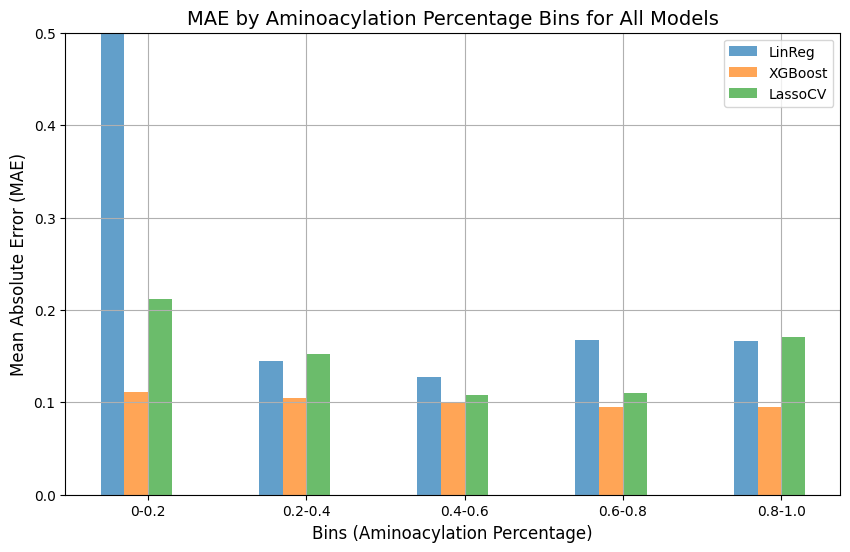

In [ ]:
def plot_combined_bin_mae_histogram(bin_mae_list, model_names, bins):
    bin_midpoints = np.arange(len(bins)-1)

    width = 0.15

    plt.figure(figsize=(10, 6))

    for i, bin_mae in enumerate(bin_mae_list):
        plt.bar(bin_midpoints + i * width - (len(bin_mae_list) / 2) * width,
                bin_mae.values, width=width, label=model_names[i], alpha=0.7)

    plt.xlabel('Bins (Aminoacylation Percentage)', fontsize=12)
    plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
    plt.title('MAE by Aminoacylation Percentage Bins for All Models', fontsize=14)

    plt.xticks(bin_midpoints, [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)], fontsize=10)

    plt.ylim(0, 0.5)

    plt.legend()

    plt.grid(True)
    plt.show()

bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

binned_mae_lr = calculate_binned_mae(lr_preds, y_test, bins)
binned_mae_xgb = calculate_binned_mae(xgboost_preds, y_test, bins)
binned_mae_lasso = calculate_binned_mae(lasso_preds, y_test, bins)

# binned_mae_model4 = calculate_binned_mae(lstm_preds, y_test, bins)
# binned_mae_model5 = calculate_binned_mae(rinalmo_preds, y_test, bins)

bin_mae_list = [binned_mae_lr, binned_mae_xgb, binned_mae_lasso]  # Add more if needed
model_names = ['LinReg', 'XGBoost', 'LassoCV']  # Corresponding model names

plot_combined_bin_mae_histogram(bin_mae_list, model_names, bins)

In [ ]:
lr_preds.shape, y_test.shape

((254, 1), (254, 1))

#### Plotting MAE as a Function of Levenshtein Distance

In [ ]:
len(lr_preds.flatten().tolist()), len(lasso_preds.flatten().tolist()), len(xgboost_preds.flatten().tolist()), len(y_test.flatten().tolist())

(254, 254, 254, 254)

In [ ]:
len(train_sequences), len(train_percentages), len(test_sequences), len(test_percentages)

(996, 996, 254, 254)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_train_reshaped.shape

((996, 91, 5), (996, 1), (254, 91, 5), (254, 1), (996, 455))

In [ ]:
from Levenshtein import distance
def nearest_neighbor_levenshtein(test_sequences, train_sequences, model_preds, y_test):
  """Assumes model_preds is in the shape (254,1) """

  levenshtein_distances = []
  closest_train_sequences = []

  for test_seq in test_sequences:
      closest_distance = float('inf')
      closest_train_seq = None
      for train_seq in train_sequences:
          dist = distance(train_seq, test_seq)
          if dist < closest_distance:
              closest_distance = dist
              closest_train_seq = train_seq
      levenshtein_distances.append(closest_distance)

  df = pd.DataFrame({
      "levenshtein_dist": levenshtein_distances,
      "preds": model_preds.flatten().tolist(),
      "actuals": y_test.flatten().tolist()
  })

  grouped_df = df.groupby("levenshtein_dist")

  mae_by_distance = grouped_df.apply(lambda x: np.mean(np.abs(x["preds"] - x["actuals"])))
  std_by_distance = grouped_df.apply(lambda x: np.std(np.abs(x["preds"] - x["actuals"])))


  return mae_by_distance, std_by_distance

mae_by_distance_lr, std_by_distance_lr = nearest_neighbor_levenshtein(test_sequences, train_sequences, lr_preds, y_test)
mae_by_distance_lasso, std_by_distance_lasso = nearest_neighbor_levenshtein(test_sequences, train_sequences, lasso_preds, y_test)
mae_by_distance_xgb, std_by_distance_xgb = nearest_neighbor_levenshtein(test_sequences, train_sequences, xgboost_preds, y_test)


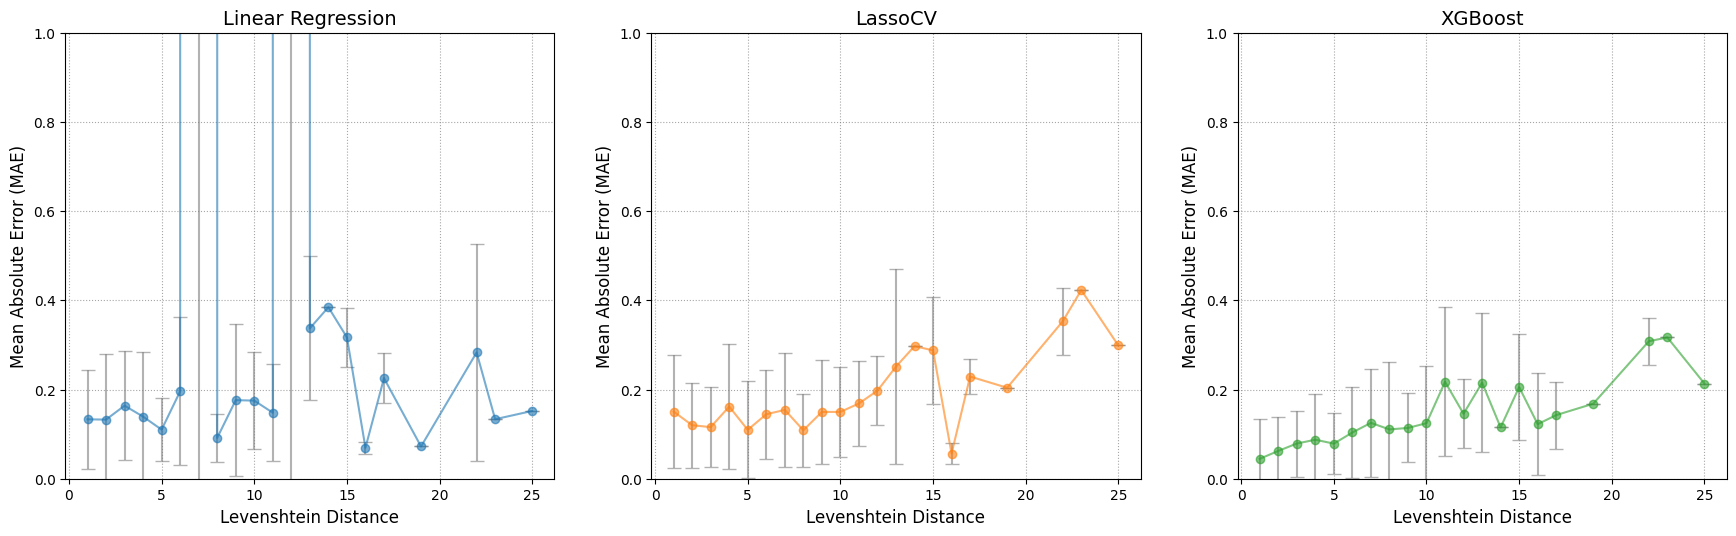

In [ ]:
models_mae_by_distance = {
    "Linear Regression": (mae_by_distance_lr, std_by_distance_lr),
    "LassoCV": (mae_by_distance_lasso, std_by_distance_lasso),
    "XGBoost": (mae_by_distance_xgb, std_by_distance_xgb)
}

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, (model_name, (mae_by_distance, std_by_distance)) in enumerate(models_mae_by_distance.items()):
    axs[i].errorbar(mae_by_distance.index, mae_by_distance.values, yerr=std_by_distance.values, fmt='-o', color=colors[i], ecolor='gray', capsize=5, alpha = 0.6)
    axs[i].set_title(model_name, fontsize=14)
    axs[i].set_xlabel("Levenshtein Distance", fontsize=12)
    axs[i].set_ylabel("Mean Absolute Error (MAE)", fontsize=12)
    axs[i].grid(True, linestyle=':', color='gray', alpha=0.7)  # Subtle grid
    axs[i].set_ylim(0, 1)  # Same y-axis limit for better comparison
    axs[i].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout(pad=3.0)

plt.show()


In [ ]:
df = pd.DataFrame({
    'lr_preds': lr_preds.flatten().tolist(),
    'lasso_preds': lasso_preds.flatten().tolist(),
    'xgboost_preds': xgboost_preds.flatten().tolist(),
    'actuals': y_test.flatten().tolist()
})

df['lr_error'] = np.abs(df['lr_preds'] - df['actuals'])
df['lasso_error'] = np.abs(df['lasso_preds'] - df['actuals'])
df['xgboost_error'] = np.abs(df['xgboost_preds'] - df['actuals'])

top_errors = df.sort_values(by='lr_error', ascending=False).head(10)

top_sequences = X_test_reshaped[top_errors.index]  # Sequences where LR performed poorly
reversed_sequences = reverse_transform(top_sequences)

top_aminoacylation = y_test[top_errors.index]

results_df = pd.DataFrame({
    'sequence': reversed_sequences,
    'actual_aminoacylation': top_aminoacylation.flatten().tolist(),
    'lr_prediction': top_errors['lr_preds'],
    'lr_error': top_errors['lr_error'],
    'lasso_prediction': top_errors['lasso_preds'],
    'xgboost_prediction': top_errors['xgboost_preds']
})


results_df

,sequence,actual_aminoacylation,lr_prediction,lr_error,lasso_prediction,xgboost_prediction
64,GGCGCCGTGGCTTAGTTGGTCAAAGCGCCTGTCTAGTAAACAGGAC...,0.137255,1.802901e+12,1.802901e+12,0.473829,0.543936
173,GGCTCGTTGGTCTAGGGTTGTGGTTCTCGCTTAGGGCGGGAGACCC...,0.129555,5.802878e+10,5.802878e+10,0.427697,0.194809
116,CGGGTGGTAGCGCAGTGGTAGCGCGCTCGGTTCGGGACTGAGAGGT...,0.888889,2.304688e-01,6.584201e-01,0.173187,0.465789
92,GGTCTCATGGTGTAATGGTTAGCACTTTGGACTTTGAATCCAGTGA...,0.866667,2.109375e-01,6.557292e-01,0.234313,0.480936
83,TGCGGATTAGCTCAGTTGGTAGTAGCGCATGACTGTTAATCATGAT...,0.607143,1.183594e+00,5.764509e-01,0.825043,0.696892
1,GGCCATCGTCTAGAGGCCTAGGACCCCGCCCTTTCACGGCGGTAGC...,0.736111,1.601562e-01,5.759549e-01,0.297637,0.483968
153,GCTTTTGTGGCGCAATAGGCAGCGCGTTCGGCTGTTAACCGAAAGG...,1.000000,4.257812e-01,5.742188e-01,0.426820,0.622147
65,GGCCCGTTGGAGAAACGGTTAACTCACATGCCTTTCACGCATGCAT...,0.057407,6.250000e-01,5.675926e-01,0.643552,0.124887
246,GCTTGGTGGTTCAATGGAAGAATTCTCGCCTGCCACGCGGGAGACC...,0.218487,7.656250e-01,5.471376e-01,0.350689,0.453788
225,CGGAGTATAGCGCAGCTTGGTTAGCGCGGTTGCTTTGGGAGCAATA...,0.857143,3.222656e-01,5.348772e-01,0.697113,0.696916
